# Decision Trees: Personal Loan Campaign Modeling

## Background & Context
AllLife Bank is a US bank that has a growing customer base. The majority of these customers are liability customers (depositors) with varying sizes of deposits. The number of customers who are also borrowers (asset customers) is quite small, and the bank is interested in expanding this base rapidly to bring in more loan business and in the process, earn more through the interest on loans. In particular, the management wants to explore ways of converting its liability customers to personal loan customers (while retaining them as depositors).

A campaign that the bank ran last year for liability customers showed a healthy conversion rate of over 9% success. This has encouraged the retail marketing department to devise campaigns with better target marketing to increase the success ratio.

## Objective
The objective of our analysis is to assist AllLife bank in building a model that will help the marketing department identify the potential customers who have a higher probability of purchasing the loan.

In [178]:
#importing necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier

# To build linear model for statistical analysis and prediction
import statsmodels.stats.api as sms
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from statsmodels.tools.tools import add_constant

# To get diferent metric scores
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, roc_curve, confusion_matrix, precision_recall_curve
from sklearn.model_selection import GridSearchCV

# For pandas profiling
from pandas_profiling import ProfileReport

warnings.filterwarnings('ignore')

# Removes the limit from the number of displayed columns and rows.
# This is so I can see the entire dataframe when I print it
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
pd.set_option('display.max_rows', 200)

#to print graph without also printing location
%matplotlib inline

In [179]:
#reading in csv
data = pd.read_csv('Loan_Modelling.csv')

In [180]:
# copying data to another varaible to avoid any changes to original data
df = data.copy()

In [181]:
#looking at the first 10 rows of the dataset
df.head(10)

,ID,Age,Experience,Income,ZIPCode,Family,CCAvg,Education,Mortgage,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1
5,6,37,13,29,92121,4,0.4,2,155,0,0,0,1,0
6,7,53,27,72,91711,2,1.5,2,0,0,0,0,1,0
7,8,50,24,22,93943,1,0.3,3,0,0,0,0,0,1
8,9,35,10,81,90089,3,0.6,2,104,0,0,0,1,0
9,10,34,9,180,93023,1,8.9,3,0,1,0,0,0,0


In [182]:
#looking at the last 10 rows of the dataset
df.tail(10)

,ID,Age,Experience,Income,ZIPCode,Family,CCAvg,Education,Mortgage,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard
4990,4991,55,25,58,95023,4,2.00,3,219,0,0,0,0,1
4991,4992,51,25,92,91330,1,1.90,2,100,0,0,0,0,1
4992,4993,30,5,13,90037,4,0.50,3,0,0,0,0,0,0
4993,4994,45,21,218,91801,2,6.67,1,0,0,0,0,1,0
4994,4995,64,40,75,94588,3,2.00,3,0,0,0,0,1,0
4995,4996,29,3,40,92697,1,1.90,3,0,0,0,0,1,0
4996,4997,30,4,15,92037,4,0.40,1,85,0,0,0,1,0
4997,4998,63,39,24,93023,2,0.30,3,0,0,0,0,0,0
4998,4999,65,40,49,90034,3,0.50,2,0,0,0,0,1,0
4999,5000,28,4,83,92612,3,0.80,1,0,0,0,0,1,1


## Notes about how to read this dataset:

<ul>
    <li>ID: Customer ID</li>
    <li>Age: Customer’s age in completed years</li>
    <li>Experience: # years of professional experience</li>
    <li>Income: Annual income of the customer (in thousand dollars)</li>
    <li>ZIP Code: Home Address ZIP code.</li>
    <li>Family: the Family size of the customer</li>
    <li>CCAvg: Average spending on credit cards per month (in thousand dollars)</li>
    <li>Education: Education Level. 1: Undergrad; 2: Graduate; 3: Advanced/Professional</li>
    <li>Mortgage: Value of house mortgage if any. (in thousand dollars)</li>
    <li>Personal_Loan: Did this customer accept the personal loan offered in the last campaign?</li>
    <li>Securities_Account: Does the customer have securities account with the bank?</li>
    <li>CD_Account: Does the customer have a certificate of deposit (CD) account with the bank?</li>
    <li>Online: Do customers use internet banking facilities?</li>
    <li>CreditCard: Does the customer use a credit card issued by any other Bank (excluding All life Bank)?</li>
</ul>

In [183]:
#We're going to go ahead and drop the ID column because it seems irrelevant for analysis
#In addition, a person's ZIPCode, their years of professional experience, and whether or not they use online services
#seems to be irrelevant when determining whether they'll pay off a loan
df.drop(['ID'], axis=1, inplace=True)
df.drop(['Experience'], axis=1, inplace=True)
df.drop(['ZIPCode'], axis=1, inplace=True)
df.drop(['Online'], axis=1, inplace=True)

In [184]:
#looking at the shape of the dataset
df.shape

(5000, 10)

### Observations:

<ul>
    <li>There are 5000 rows and 13 columns (variables) after dropping the "ID" column.</li>
</ul>

In [185]:
#checking for duplicates in the dataset
df[df.duplicated()].count()

Age                   31
Income                31
Family                31
CCAvg                 31
Education             31
Mortgage              31
Personal_Loan         31
Securities_Account    31
CD_Account            31
CreditCard            31
dtype: int64

### Observations:

<ul>
    <li>There are no duplicated values.</li>
</ul>

In [186]:
#checking for null values
data.isnull().sum()

ID                    0
Age                   0
Experience            0
Income                0
ZIPCode               0
Family                0
CCAvg                 0
Education             0
Mortgage              0
Personal_Loan         0
Securities_Account    0
CD_Account            0
Online                0
CreditCard            0
dtype: int64

### Observations:

<ul>
    <li>There are no null values.</li>
</ul>

In [187]:
#checking datatypes
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  5000 non-null   int64  
 1   Age                 5000 non-null   int64  
 2   Experience          5000 non-null   int64  
 3   Income              5000 non-null   int64  
 4   ZIPCode             5000 non-null   int64  
 5   Family              5000 non-null   int64  
 6   CCAvg               5000 non-null   float64
 7   Education           5000 non-null   int64  
 8   Mortgage            5000 non-null   int64  
 9   Personal_Loan       5000 non-null   int64  
 10  Securities_Account  5000 non-null   int64  
 11  CD_Account          5000 non-null   int64  
 12  Online              5000 non-null   int64  
 13  CreditCard          5000 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 547.0 KB


In [188]:
#converting datatypes for analysis
df["Family"] = df["Family"].astype("category")
df["Education"] = df["Education"].astype("category")
df["Personal_Loan"] = df["Personal_Loan"].astype("bool")
df["Securities_Account"] = df["Securities_Account"].astype("bool")
df["CD_Account"] = df["CD_Account"].astype("bool")
df["CreditCard"] = df["CreditCard"].astype("bool")

In [189]:
#checking datatypes to ensure they're all converted properly
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   Age                 5000 non-null   int64   
 1   Income              5000 non-null   int64   
 2   Family              5000 non-null   category
 3   CCAvg               5000 non-null   float64 
 4   Education           5000 non-null   category
 5   Mortgage            5000 non-null   int64   
 6   Personal_Loan       5000 non-null   bool    
 7   Securities_Account  5000 non-null   bool    
 8   CD_Account          5000 non-null   bool    
 9   CreditCard          5000 non-null   bool    
dtypes: bool(4), category(2), float64(1), int64(3)
memory usage: 186.0 KB


In [190]:
#looking at a general overview of our quantitative varibles
df.describe()

,Age,Income,CCAvg,Mortgage
count,5000.000000,5000.000000,5000.000000,5000.000000
mean,45.338400,73.774200,1.937938,56.498800
std,11.463166,46.033729,1.747659,101.713802
min,23.000000,8.000000,0.000000,0.000000
25%,35.000000,39.000000,0.700000,0.000000
50%,45.000000,64.000000,1.500000,0.000000
75%,55.000000,98.000000,2.500000,101.000000
max,67.000000,224.000000,10.000000,635.000000


### Observations:

<ul>
    <li>The average age of customers surveyed is 45, which matches precisely to the median, indicating a lack of skewness.</li>
    <li>The age of customers surveyed ranges from 23-67 years old.</li>
    <li>The average income of the dataset is about 73-74k/yr, a bit higher than the 64k/yr median.</li>
    <li>CCAvg is interesting, because the average spending is a little under 2k/mo, however, for those who do not have credit cards, they just have 0's for their monthly spending. Does this indicate that the average monthly spending is actually much higher due to the skewness from those who don't have credit cards? How do we accommodate for this?</li>
    <li>Simiarly to our observations of CCAvg, many individuals do not have a mortgage. This skews the median to be 0, with the mean being 56k due to the large mortgages for those who do have one.</li>
</ul>

In [191]:
#looking at a general overview of our qualitative variables
df.describe(include=["category","bool"])

,Family,Education,Personal_Loan,Securities_Account,CD_Account,CreditCard
count,5000,5000,5000,5000,5000,5000
unique,4,3,2,2,2,2
top,1,1,False,False,False,False
freq,1472,2096,4520,4478,4698,3530


### Observations:

<ul>
    <li>A little under 30% of customers (1472/5000) are a family of 1. This accounts for most of the customers surveyed.</li>
    <li>~42% (2096/5000) of customers fall into the undergraduate level of education.</li>
</ul>

## Exploratory Data Analysis

In [192]:
# While doing uni-variate analysis of numerical variables we want to study their central tendency and dispersion.
# Let us write a function that will help us create boxplots and histograms for any input numerical variables.
# This function takes the numerical column as the input and returns the boxplots and histograms for the variable.
# This will also help us write faster and cleaner code.
def histogram_boxplot(data, xlabel = None, title = None, font_scale=1, figsize=(15,7), bins = None):
    """ Boxplot and histogram combined
    data: 1-d data array
    xlabel: xlabel 
    title: title
    font_scale: the scale of the font (default 2)
    figsize: size of fig (default (9,8))
    bins: number of bins (default None / auto)

    
    """
    mean = np.mean(data)

    sns.set(font_scale=font_scale) # setting the font scale of the seaborn
    f2, (ax_box2, ax_hist2) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.25, .75)}, figsize=figsize) # creating the 2 subplot
    sns.boxplot(data, ax=ax_box2,showmeans=True,color="steelblue") # boxplot will be created and a star will indicate the mean value of the column
    sns.distplot(data,kde=False, ax=ax_hist2, bins=bins,palette="winter") if bins else sns.distplot(data,kde=False, ax=ax_hist2,color="black") # histogram will be made
    ax_hist2.axvline(mean, color='g', linestyle='--') # mean will shown as vertical line in the histogram
    if xlabel: ax_hist2.set(xlabel=xlabel) # xlabel
    if title: ax_box2.set(title=title) # title of the graph
    plt.show() # for plotting the graph

## Observations on Age:

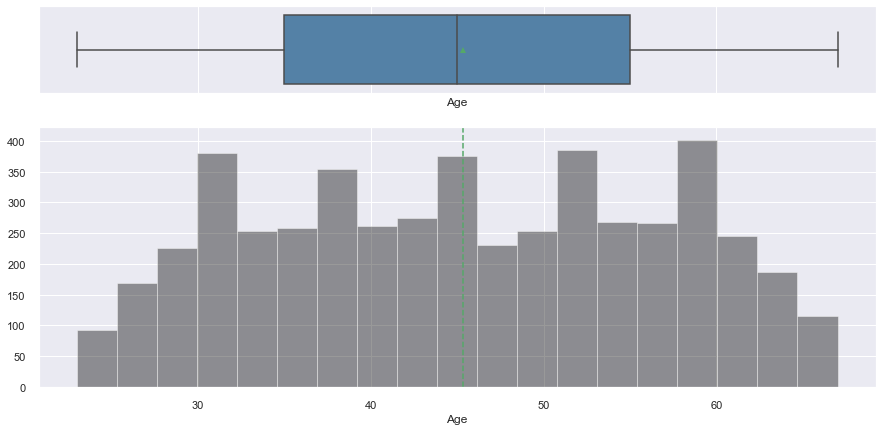

In [193]:
histogram_boxplot(df["Age"])

### Observations:

<ul>
    <li>The distribution seems to be fairly evenly distributed, with the mean and median to be fairly equal.</li>
    <li>There doesn't seem to be much skewness in age.</li>
</ul>

## Observations on Income:

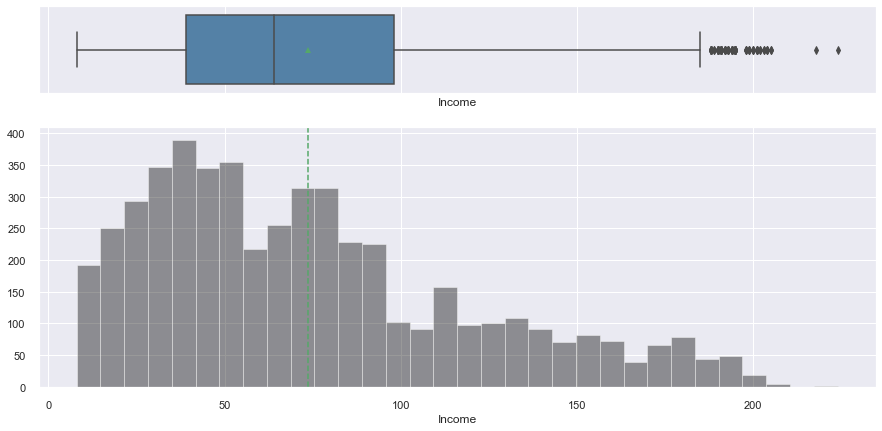

In [194]:
histogram_boxplot(df["Income"])

### Observations:

<ul>
    <li>There seems to be some skewness to the right, indicated by a mean that is higher than the median.</li>
    <li>50% of the sample make 64k/yr or less, however despite this, the mean income sits at ~74k/yr.</li>
</ul>

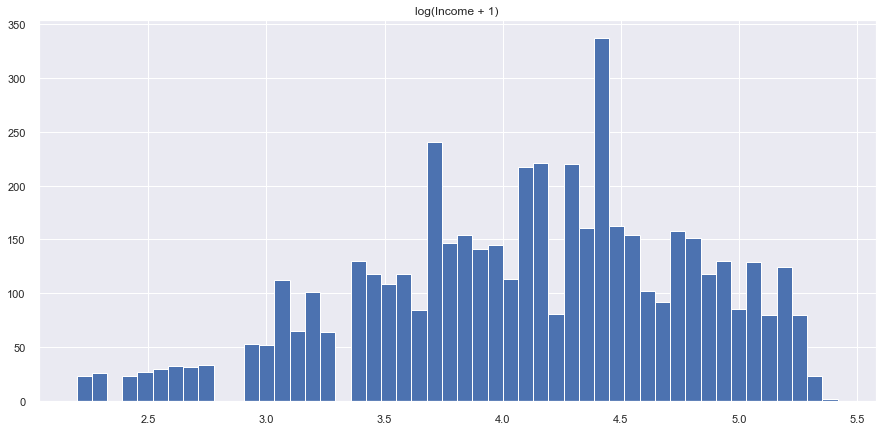

In [195]:
#Due to the skewness of the variable, we are going to apply a logarithmic transformation
plt.hist(np.log(df['Income'] + 1), 50)
plt.gcf().set_size_inches(15, 7)
plt.title('log(Income + 1)')
plt.show()

## Observations on CCAvg:

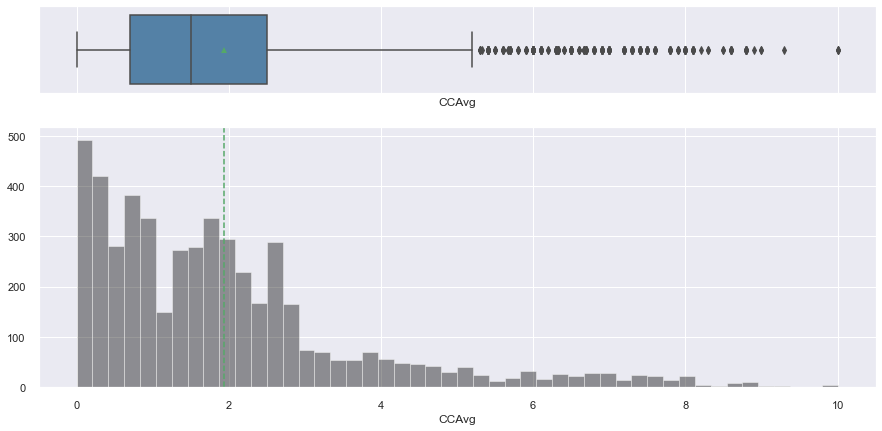

In [196]:
histogram_boxplot(df["CCAvg"])

### Observations:

<ul>
    <li>There is immense skewness when examining CCAvg. As noted in a previous observation, I believe this is due to the possibility that some individuals do not own a credit card and therefore their monthly CCAvg must be at 0.</li>
    <li>Taking this into account, it seems that despite how many 0's are in this variable, the avg monthly credit card spending sits ~2k/mo. If we somehow accommodate for the 0's, will we find that on average, people actually spend more than 2k/mo?</li>
</ul>

In [197]:
#dropping the rows where CCAvg = 0, to understand and examine the distribution for those who actually have a credit card.
CCAvg_true = df[df.CCAvg != 0]

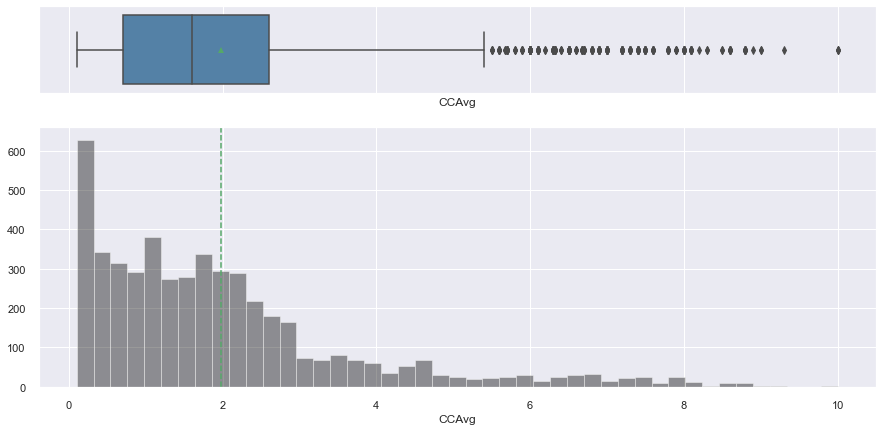

In [198]:
histogram_boxplot(CCAvg_true["CCAvg"])

In [199]:
CCAvg_true["CCAvg"].describe()

count    4894.000000
mean        1.979912
std         1.742802
min         0.100000
25%         0.700000
50%         1.600000
75%         2.600000
max        10.000000
Name: CCAvg, dtype: float64

### Observations:

<ul>
    <li>Interestingly enough, despite dropping all the 0's, the mean does not increase by much and only increases from the previous 1.93k to 1.97k.</li>
    <li>There is also a slight increase in the median, going from 1.5k previously to 1.6k now.</li>
</ul>

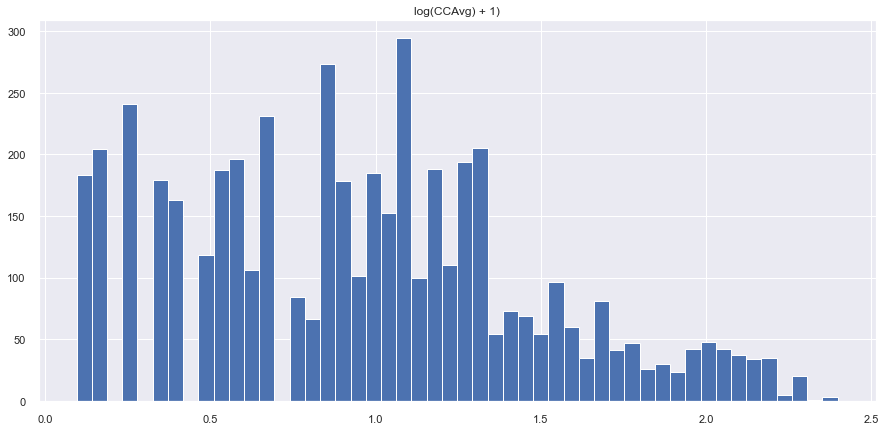

In [200]:
#Due to the skewness of the variable, we are going to apply a logarithmic transformation
plt.hist(np.log(CCAvg_true['CCAvg'] + 1), 50)
plt.gcf().set_size_inches(15, 7)
plt.title('log(CCAvg) + 1)')
plt.show()

## Observations on Mortgage:

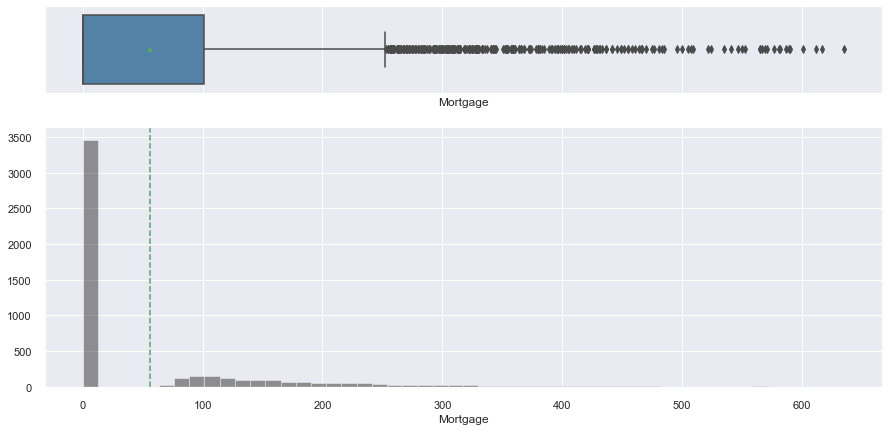

In [201]:
histogram_boxplot(df["Mortgage"])

### Observations:

<ul>
    <li>Similarly, in our observations of the previous 2 variables, there are many 0's when examining the Mortgage variable.</li>
    <li>I believe we must accommodate for these 0's and examine the true distribution for those who DO have a mortgage, by dropping the 0's.</li>
</ul>

In [202]:
#dropping the rows where Mortgage = 0, to understand and examine the distribution for those who actually do have a mortgage.
mortgage_true = df[df.Mortgage != 0]

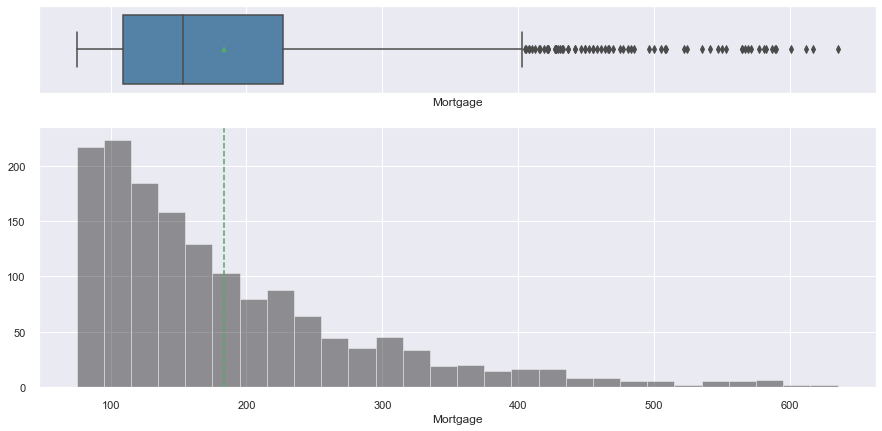

In [203]:
histogram_boxplot(mortgage_true["Mortgage"])

In [204]:
mortgage_true["Mortgage"].describe()

count    1538.000000
mean      183.676203
std       101.361226
min        75.000000
25%       109.000000
50%       153.000000
75%       227.000000
max       635.000000
Name: Mortgage, dtype: float64

### Observations:

<ul>
    <li>Now that we've dropped the 0's in the variable, the distribution seems to be far easier to understand. There still appears to be a considerable amount of skewness, but the mean and median are far more apparent.</li>
    <li>The mean Mortgage for customers surveyed is 183k, vastly different from the 56k we observed before we dropped the 0's.</li>
    <li>The median of Mortgage seems to be 153k, also vastly different from the previously observed median of 0.</li>
</ul>

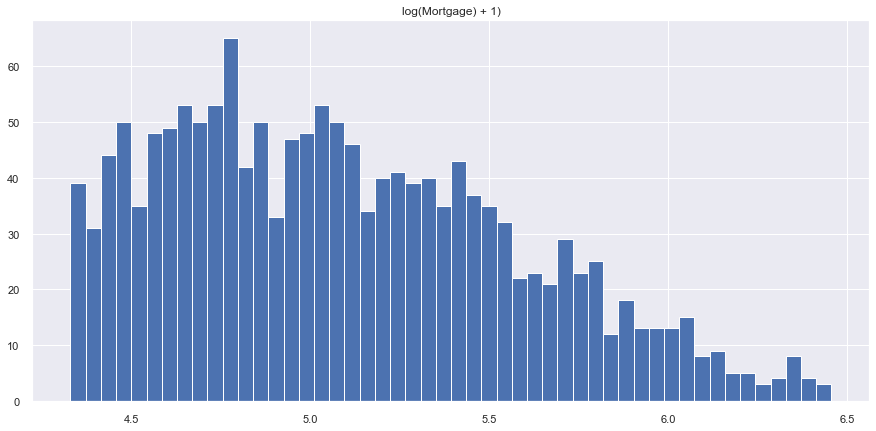

In [205]:
#Due to the skewness of the variable, we are going to apply a logarithmic transformation
plt.hist(np.log(mortgage_true['Mortgage'] + 1), 50)
plt.gcf().set_size_inches(15, 7)
plt.title('log(Mortgage) + 1)')
plt.show()

In [206]:
# Function to create barplots that indicate percentage for each category.

def perc_on_bar(plot, feature):
    '''
    plot
    feature: categorical feature
    the function won't work if a column is passed in hue parameter
    '''
    total = len(feature) # length of the column
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total) # percentage of each class of the category
        x = p.get_x() + p.get_width() / 2 - 0.05 # width of the plot
        y = p.get_y() + p.get_height()           # hieght of the plot
        ax.annotate(percentage, (x, y), size = 12) # annotate the percantage 
    plt.show() # show the plot

## Observations on Family:

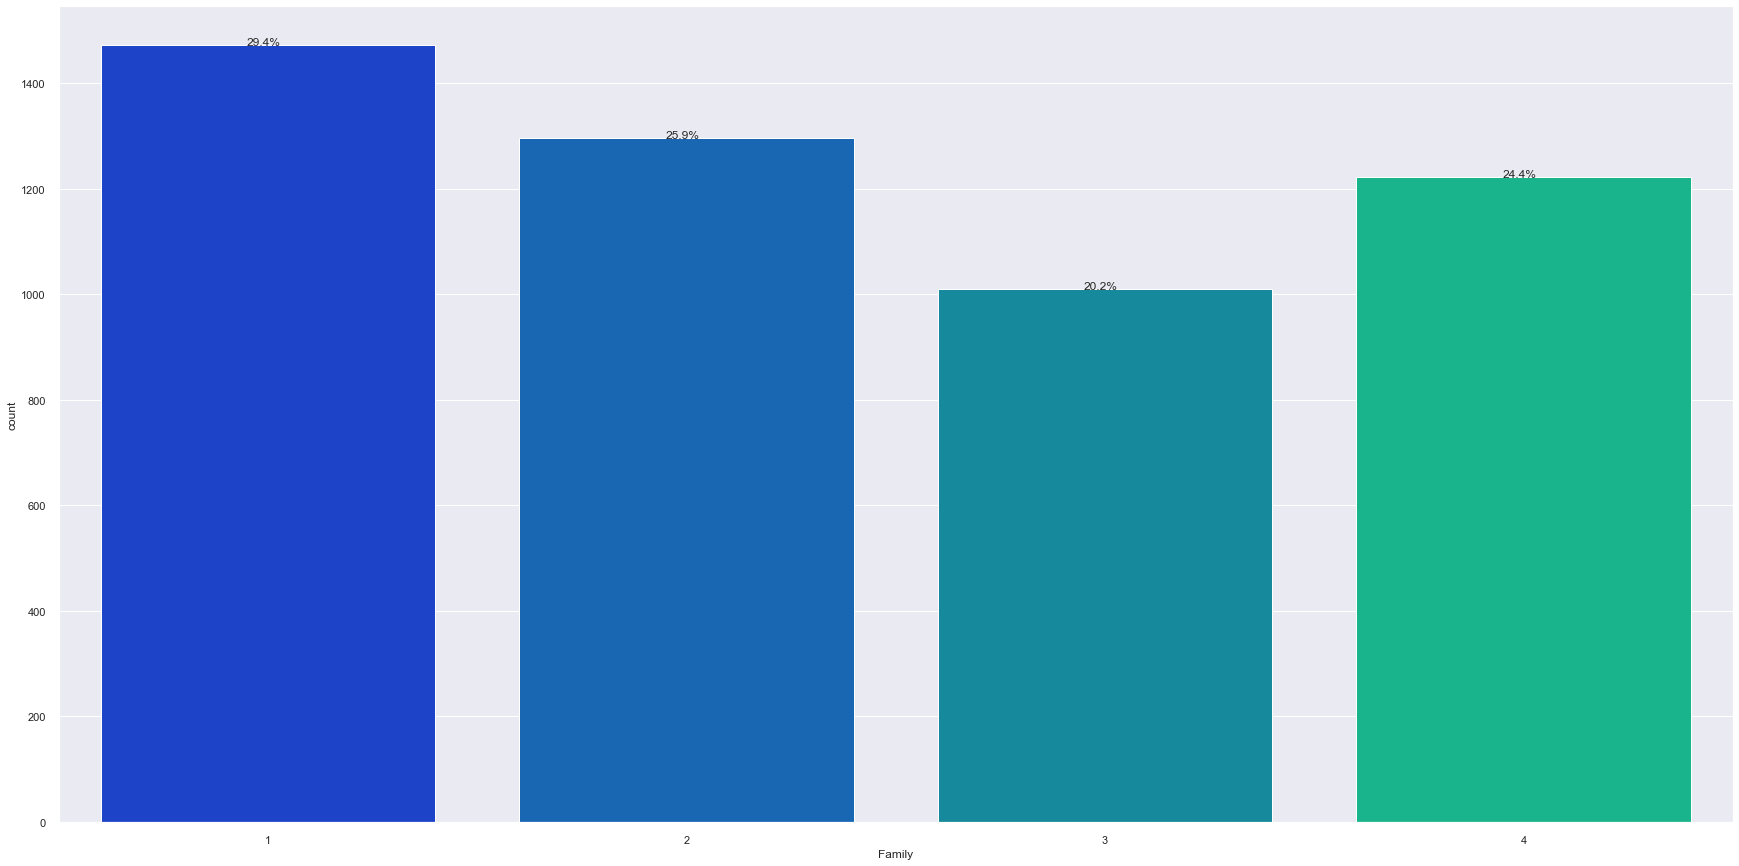

In [207]:
plt.figure(figsize=(30,15))
ax = sns.countplot(df["Family"],palette='winter')
perc_on_bar(ax,df["Family"])

### Observations:

<ul>
    <li>As stated during an earlier observation, most customers (~30%) surveyed consist of a family of 1.</li>
</ul>

## Observations on Education:

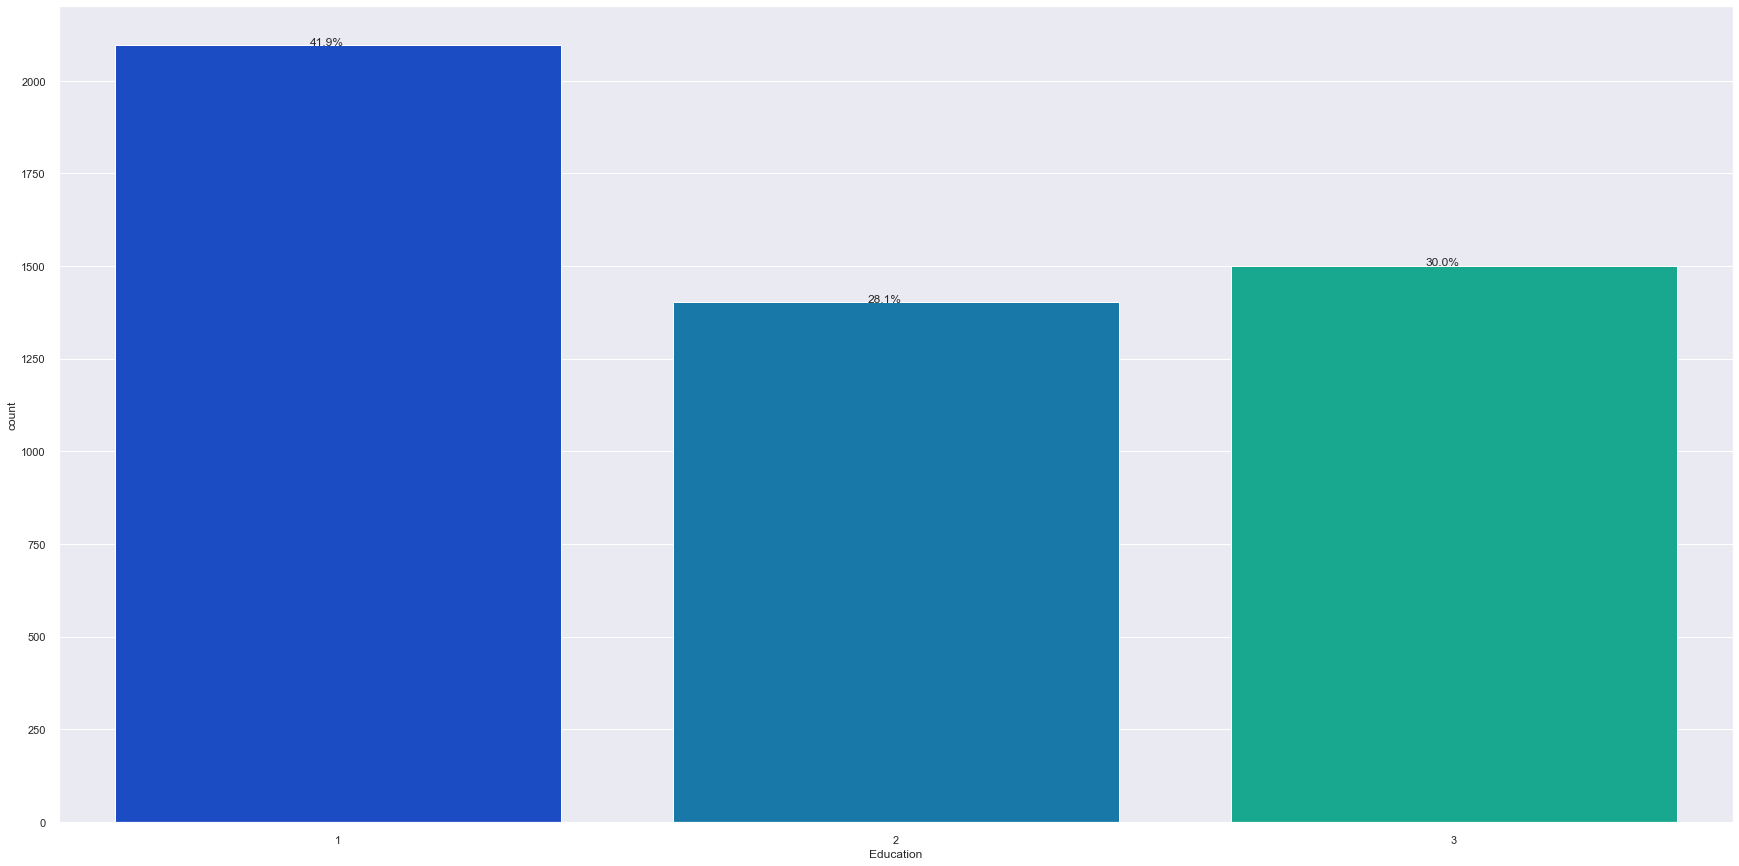

In [208]:
plt.figure(figsize=(30,15))
ax = sns.countplot(df["Education"],palette='winter')
perc_on_bar(ax,df["Education"])

### Observations:

<ul>
    <li>It seems that most individuals surveyed fall under Education lvl 1, which is undergrad. This accounts for close to 42% of the individuals surveyed.</li>
</ul>

## Observations on Personal_Loan:

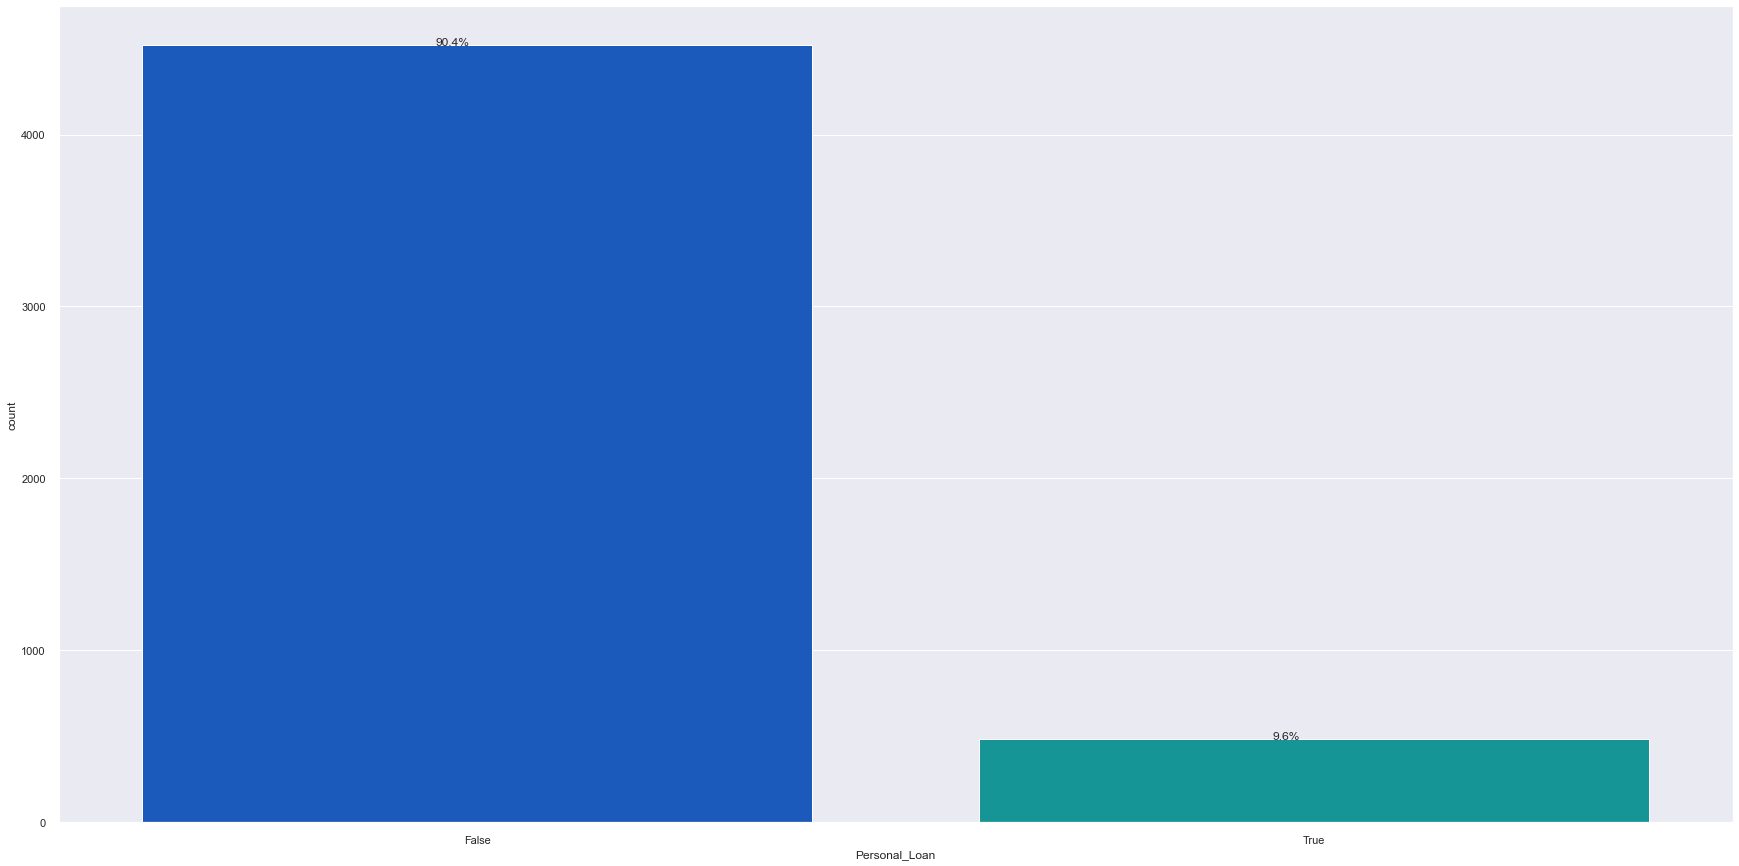

In [209]:
plt.figure(figsize=(30,15))
ax = sns.countplot(df["Personal_Loan"],palette='winter')
perc_on_bar(ax,df["Personal_Loan"])

### Observations:

<ul>
    <li>An overwhelmingly large portion (90.4%) of customers surveyed do not have a personal loan with AllLife Bank.</li>
    <li>As this is the target variable, we will further analyze the distribution of customers that make up the 9.6% of customers that do have a loan.</li>
</ul>

## Observations on Securities_Account:

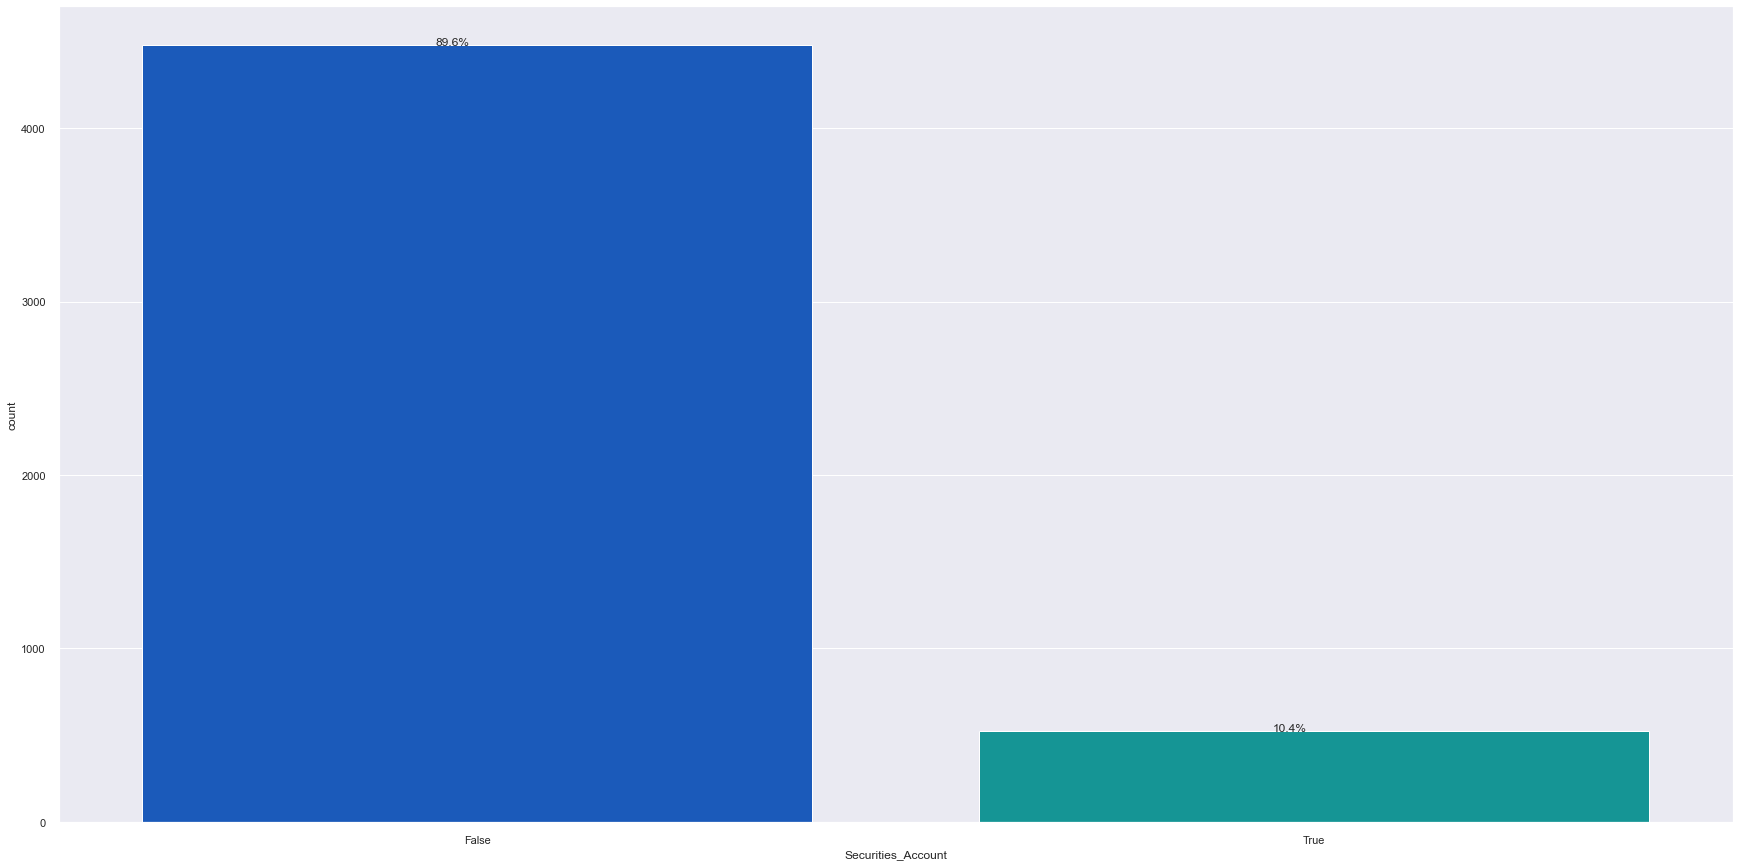

In [210]:
plt.figure(figsize=(30,15))
ax = sns.countplot(df["Securities_Account"],palette='winter')
perc_on_bar(ax,df["Securities_Account"])

### Observations:

<ul>
    <li>Though still an overwhelming majority (89.6%) of customers, more customers do seem to have Securities Accounts with AllLife than personal loans.</li>
</ul>

## Observations on CD_Account:

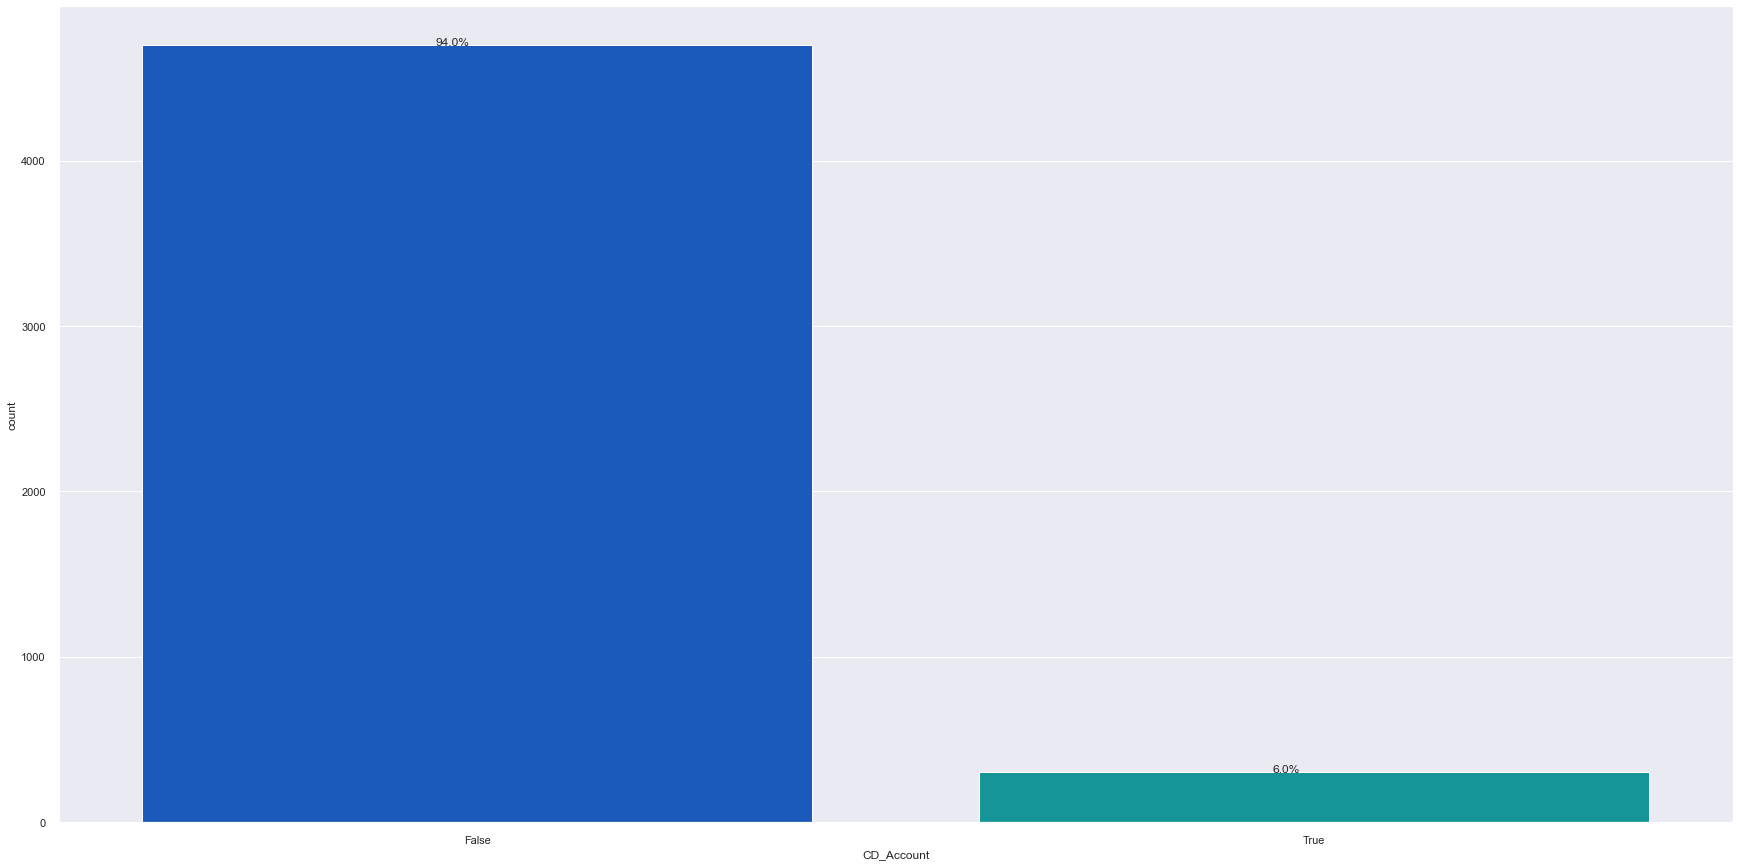

In [211]:
plt.figure(figsize=(30,15))
ax = sns.countplot(df["CD_Account"],palette='winter')
perc_on_bar(ax,df["CD_Account"])

### Observations:

<ul>
    <li>It seems that CD accounts are AllLife Bank's least popular product, with 94.0% of customers surveyed reporting that they do not have a CD account open.</li>
</ul>

## Observations on CreditCard:

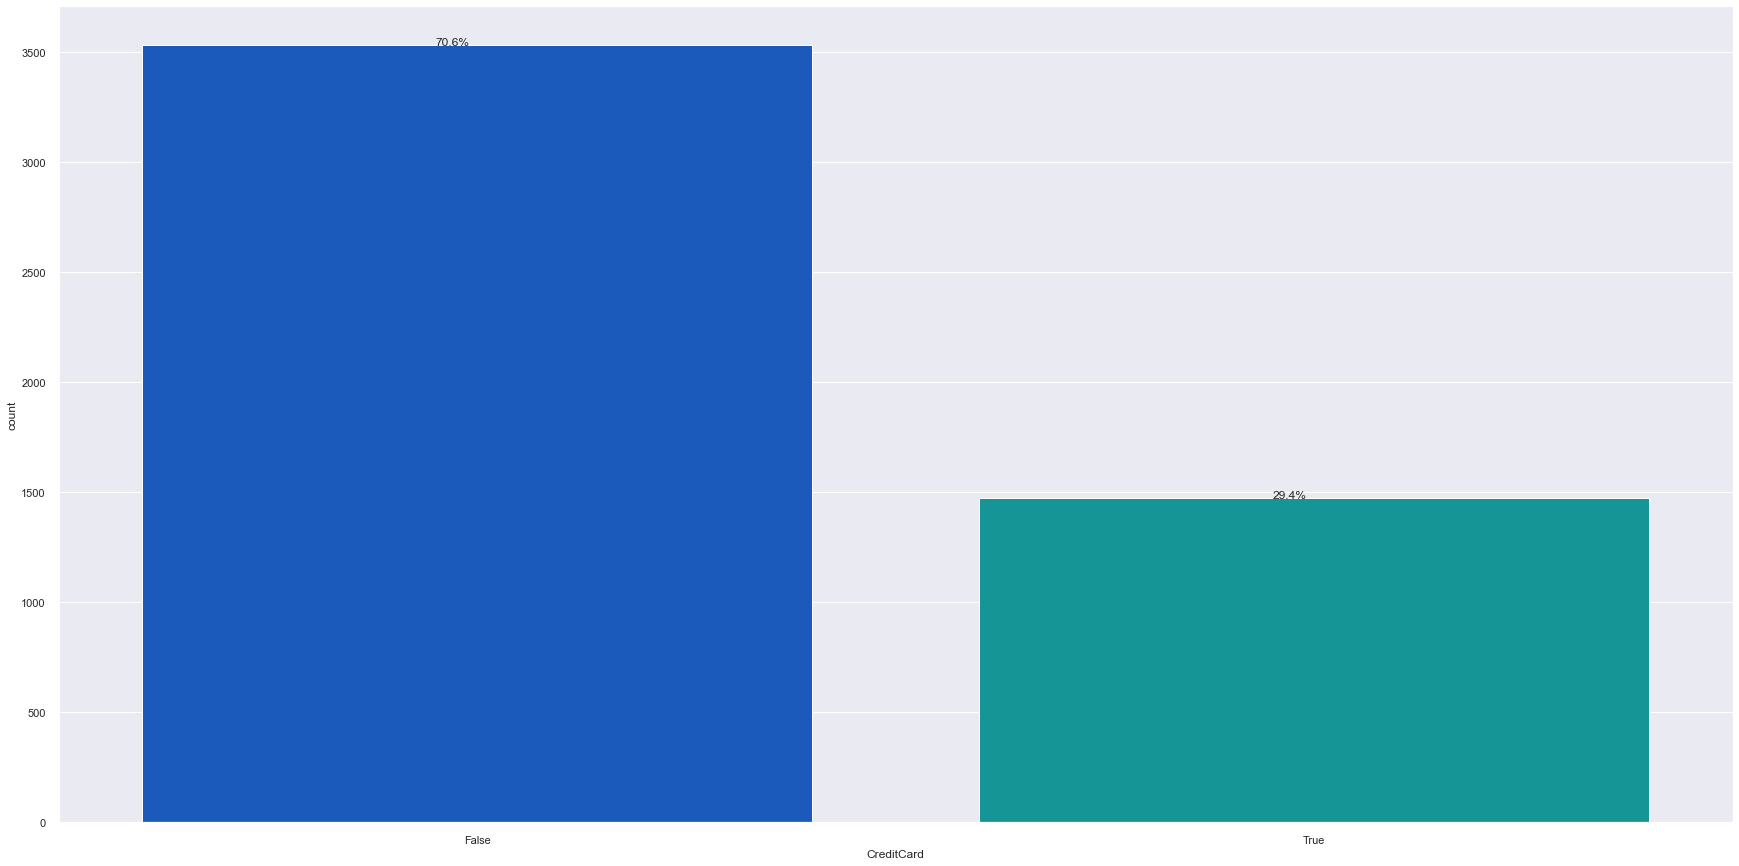

In [212]:
plt.figure(figsize=(30,15))
ax = sns.countplot(df["CreditCard"],palette='winter')
perc_on_bar(ax,df["CreditCard"])

### Observations:

<ul>
    <li>A little under 30% of customers surveyed reported that they DO have a Credit Card open, even if it not with AllLife Bank.</li>
    <li>This is interesting to note because it seems to be a popular product that garners interest over time.</li>
</ul>

## Bivariate Analysis

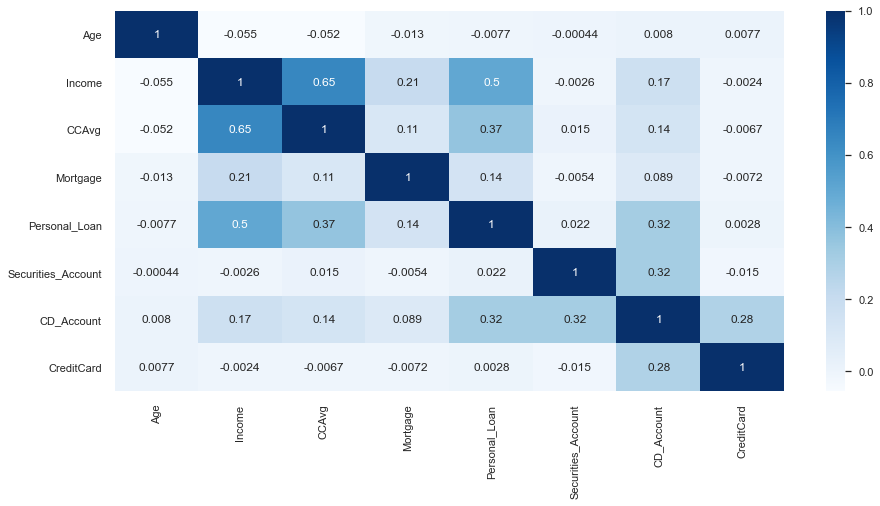

In [213]:
plt.figure(figsize=(15,7))
sns.heatmap(df.corr(),annot=True, cmap="Blues")
plt.show()

### Observations:

<ul>
    <li>The strongest correlations to note are between CCAvg and Income at 0.65 and between Personal_Loan and Income at 0.5.</li>
    <li>Unsurprisingly, individuals with higher income are more likely to be able to afford credit products that garner interest.</li>
    <li>After noting the correlation between the above variables, it is not surprising that we also see a slight correlation between CCAvg and Personal_Loan at 0.37, and between Income and Mortgage at 0.21.</li>
</ul>

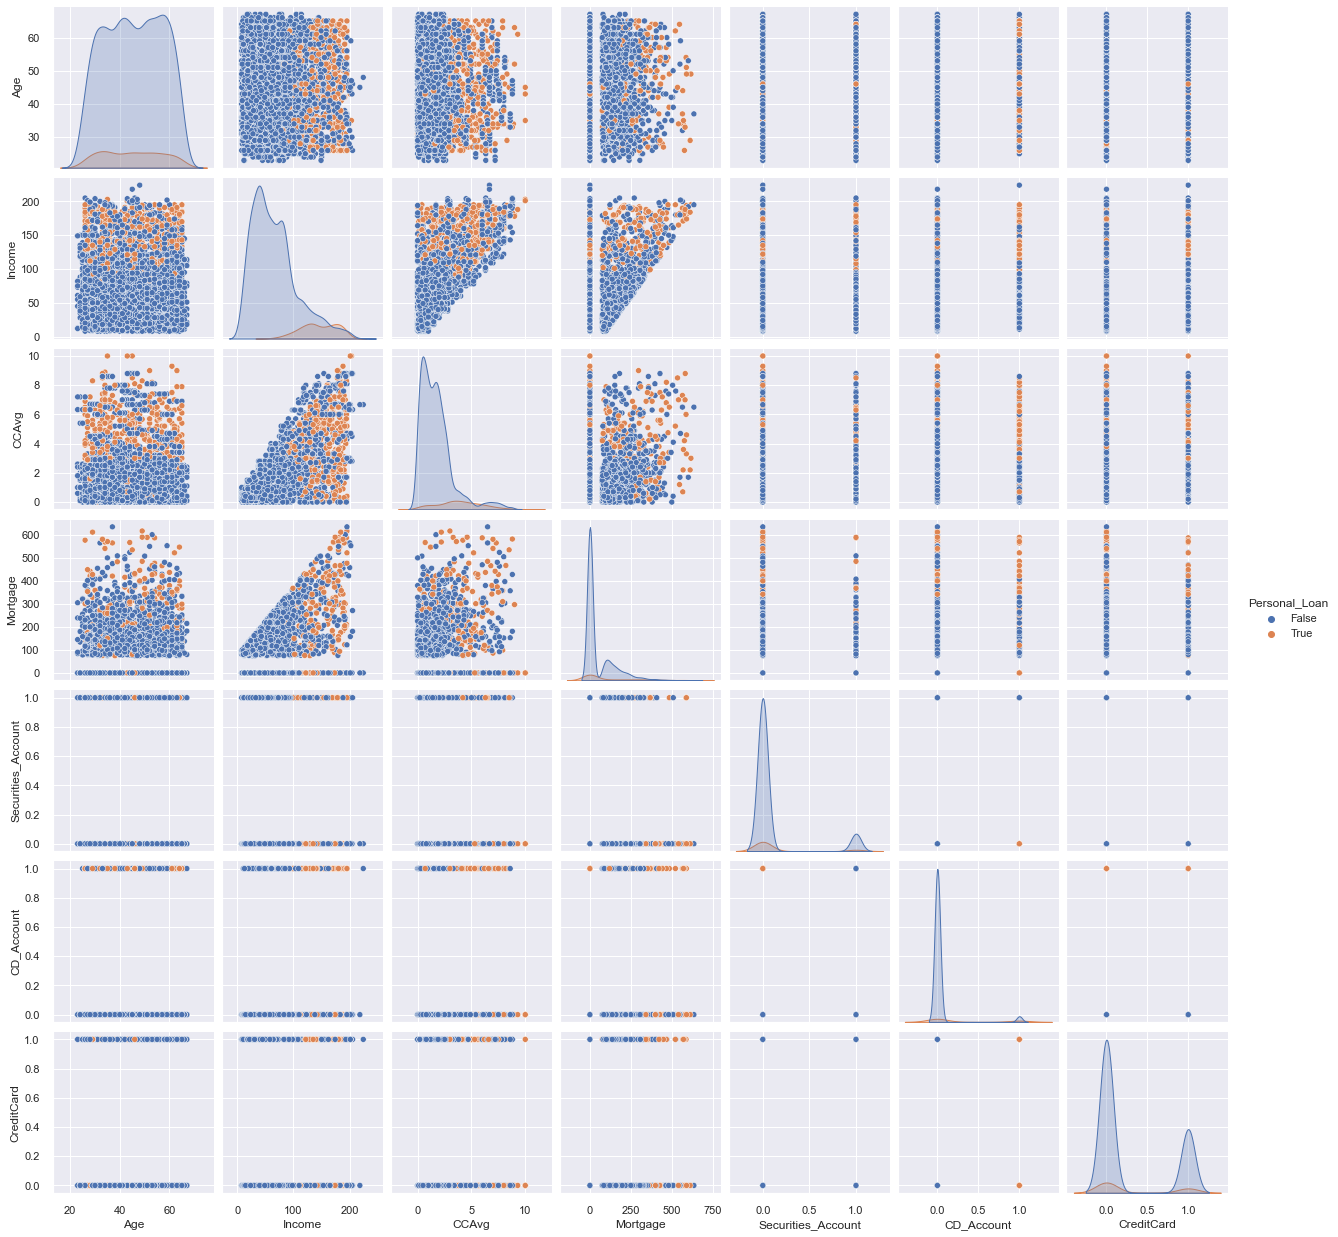

In [214]:
sns.pairplot(data=df,hue="Personal_Loan")
plt.show()

### Observations:

<ul>
    <li>Interestingly but not surprisingly, it seems that most individuals who currently do have a personal loan with AllLife Bank tend to have higher income and also seem to be younger individuals.</li>
    <li>Individuals who have personal loans also tend to spend more more monthly on their credit cards and have higher mortgages.</li>
    <li>This is interesting to note because it seems that currently, the customers who do and do not have personal loans seem to be quite different demographically.</li>
</ul>

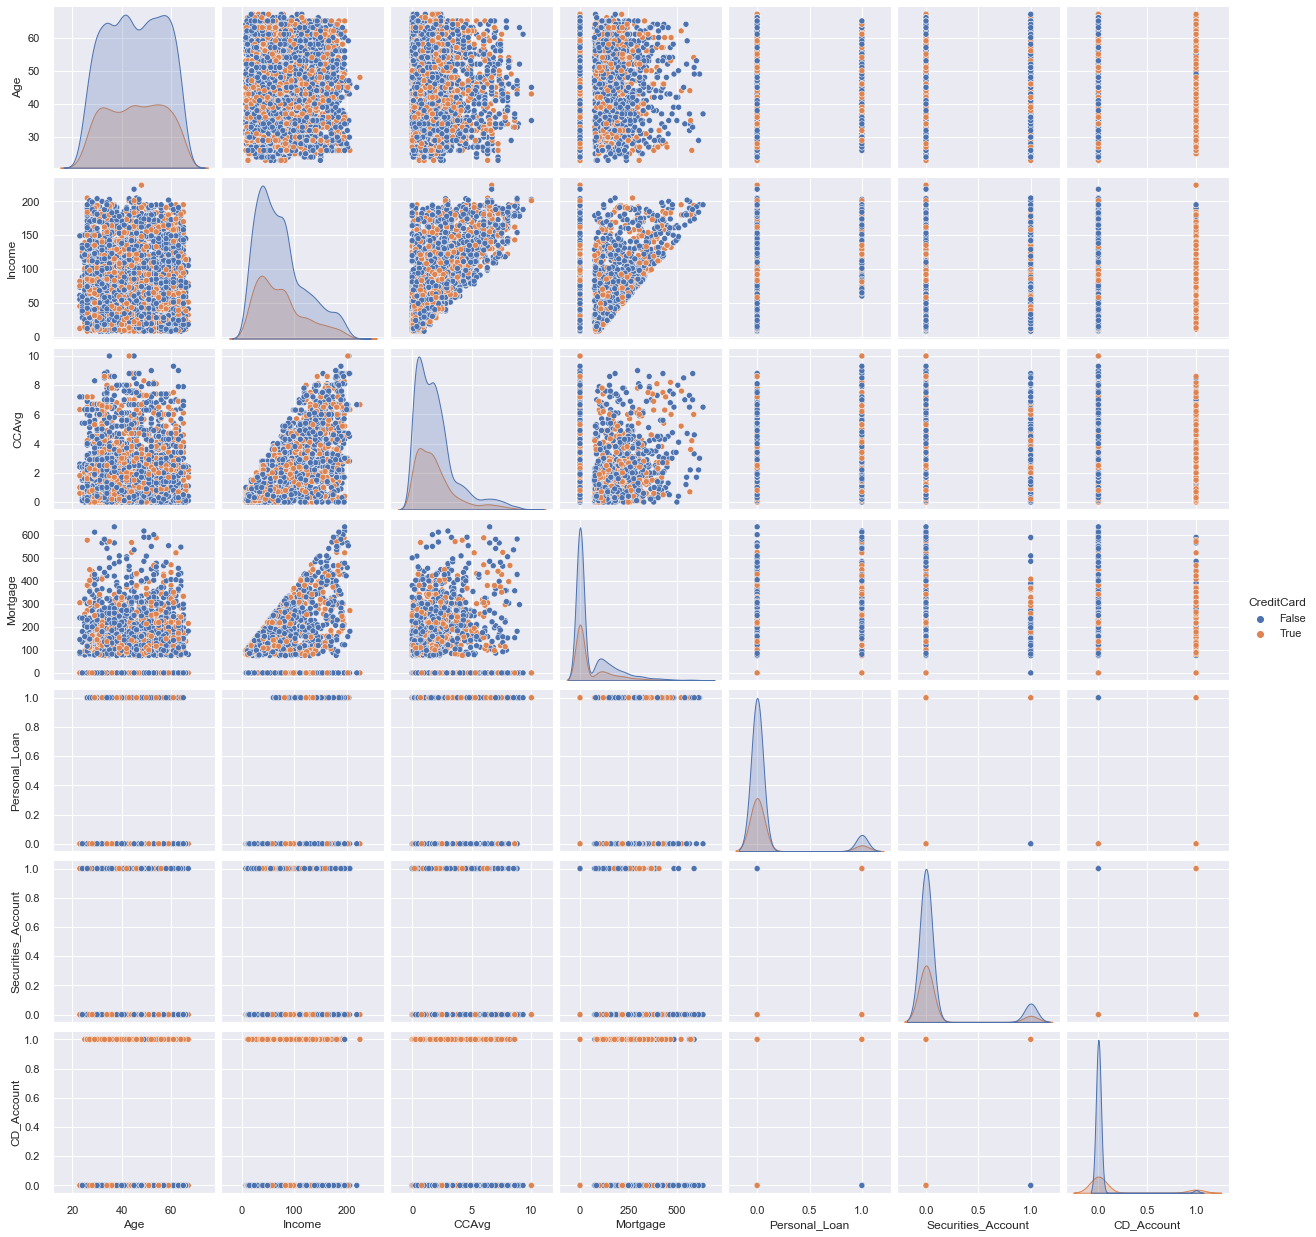

In [215]:
sns.pairplot(data=df,hue="CreditCard")
plt.show()

### Observations:

<ul>
    <li>While not the exact target variable, I believe we should have a look at CreditCard because it has the potential to be a very profitable product for AllLife Bank since we are interesting in making profits from interest on borrowed products.</li>
    <li>Though profits garnered from interest are far less than that from big-ticket items such as mortgages or personal loans, on a grand scale, credit cards might be a good product to push.</li>
    <li>If we look at the demographic for individuals that have credit cards, we do see that there is FAR more variability in the demographic. Does this imply accessibility for customers? Or could this potentially serve as a gateway product to convert an individual to an asset customer?</li>
</ul>

## Personal_Loan in relation to Age, Income, CCAvg, and Mortgage

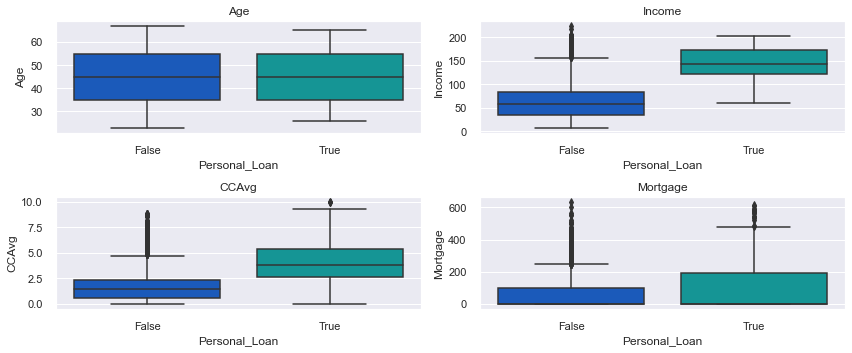

In [216]:
cols = mortgage_true[['Age', 'Income', 'CCAvg', 'Mortgage']].columns.tolist()
plt.figure(figsize=(12,7))

for i, variable in enumerate(cols):
                     plt.subplot(3,2,i+1)
                     sns.boxplot(df["Personal_Loan"],df[variable],palette="winter")
                     plt.tight_layout()
                     plt.title(variable)
plt.show()

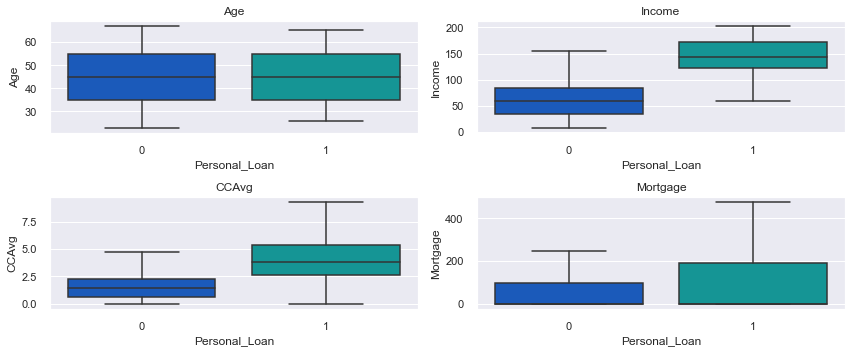

In [217]:
# the same analysis as above except with outlier treatment
cols = mortgage_true[['Age', 'Income', 'CCAvg', 'Mortgage']].columns.tolist()
plt.figure(figsize=(12,7))

for i, variable in enumerate(cols):
                     plt.subplot(3,2,i+1)
                     sns.boxplot(data["Personal_Loan"],data[variable],palette="winter",showfliers=False)
                     plt.tight_layout()
                     plt.title(variable)
plt.show()

### Observations:

<ul>
    <li>Most notably, and every visualization has supported this idea thus far, it seems that income does play the largest role in whether or not a customer has a personal loan with AllLife Bank.</li>
    <li>In addition, monthly CCAvg also seems to factor in quite a bit in regards to whether or not an individual has a personal loan. Could it be because they are experienced borrowers, or are they simply used to making high monthly payments on their cards and other borrowed services?</li>
</ul>

In [218]:
#examination of Personal_Loan against other categorical/bool variables
def stacked_plot(x):
    sns.set(palette='nipy_spectral')
    tab1 = pd.crosstab(x,df['Personal_Loan'],margins=True)
    print(tab1)
    print('-'*120)
    tab = pd.crosstab(x,df['Personal_Loan'],normalize='index')
    tab.plot(kind='bar',stacked=True,figsize=(10,5))
    plt.legend(loc='lower left', frameon=False)
    plt.legend(loc="upper left", bbox_to_anchor=(1,1))
    plt.show()

### Personal_Loan vs Family

Personal_Loan  False  True   All
Family                          
1               1365   107  1472
2               1190   106  1296
3                877   133  1010
4               1088   134  1222
All             4520   480  5000
------------------------------------------------------------------------------------------------------------------------


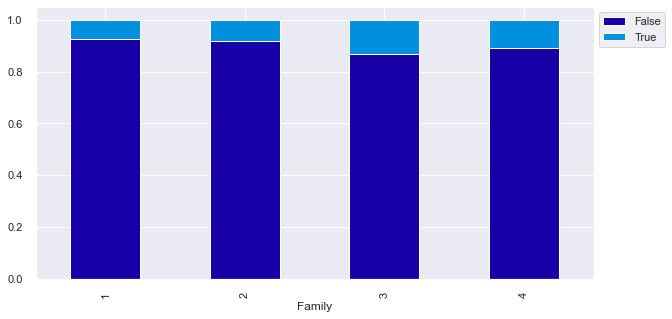

In [219]:
stacked_plot(df['Family'])

### Personal_Loan vs Education

Personal_Loan  False  True   All
Education                       
1               2003    93  2096
2               1221   182  1403
3               1296   205  1501
All             4520   480  5000
------------------------------------------------------------------------------------------------------------------------


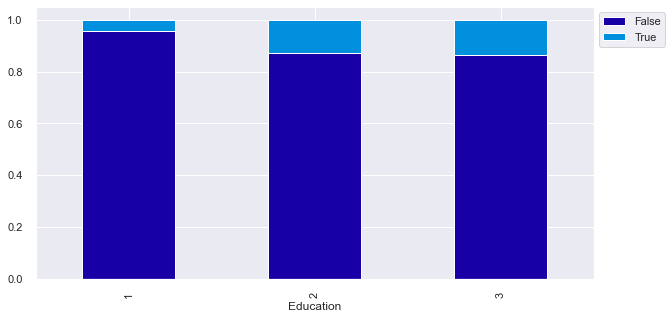

In [220]:
stacked_plot(df['Education'])

### Personal_Loan vs CreditCard

Personal_Loan  False  True   All
CreditCard                      
False           3193   337  3530
True            1327   143  1470
All             4520   480  5000
------------------------------------------------------------------------------------------------------------------------


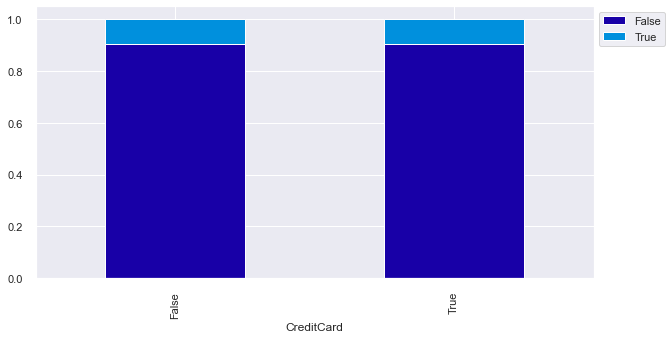

In [221]:
stacked_plot(df['CreditCard'])

In [222]:
### Function to plot distributions and Boxplots of customers
def plot(x,target='Personal_Loan'):
    fig,axs = plt.subplots(2,2,figsize=(12,10))
    axs[0, 0].set_title('Distribution of a customer who requires a Personal Loan')
    sns.distplot(data[(data[target] == 1)][x],ax=axs[0,0],color='teal')
    axs[0, 1].set_title("Distribution of a customer who doesn't require a Personal Loan")
    sns.distplot(data[(data[target] == 0)][x],ax=axs[0,1],color='orange')
    axs[1,0].set_title('Boxplot w.r.t Personal Loan')
    sns.boxplot(data[target],data[x],ax=axs[1,0],palette='gist_rainbow')
    axs[1,1].set_title('Boxplot w.r.t Personal Loan - Without outliers')
    sns.boxplot(data[target],data[x],ax=axs[1,1],showfliers=False,palette='gist_rainbow')
    plt.tight_layout()
    plt.show()

### Personal_Loan vs Age

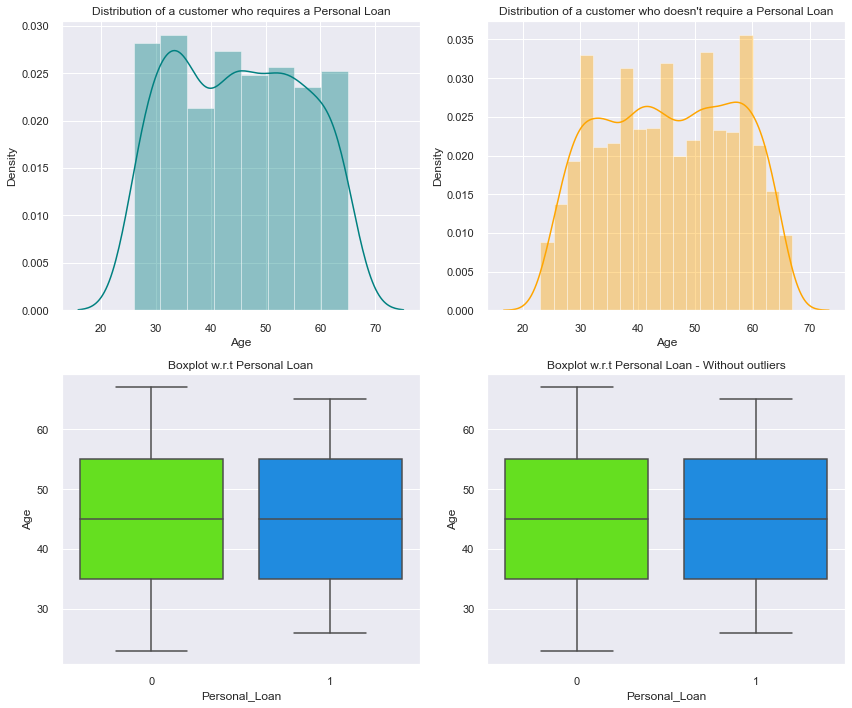

In [223]:
plot('Age')

### Personal_Loan vs Exp

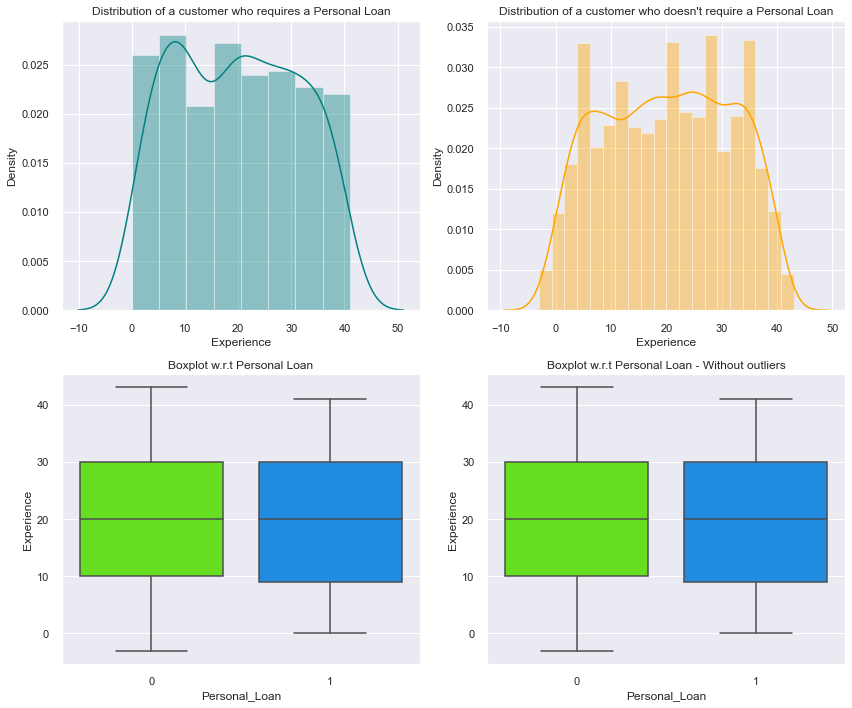

In [224]:
plot('Experience')

### Personal_Loan vs Income

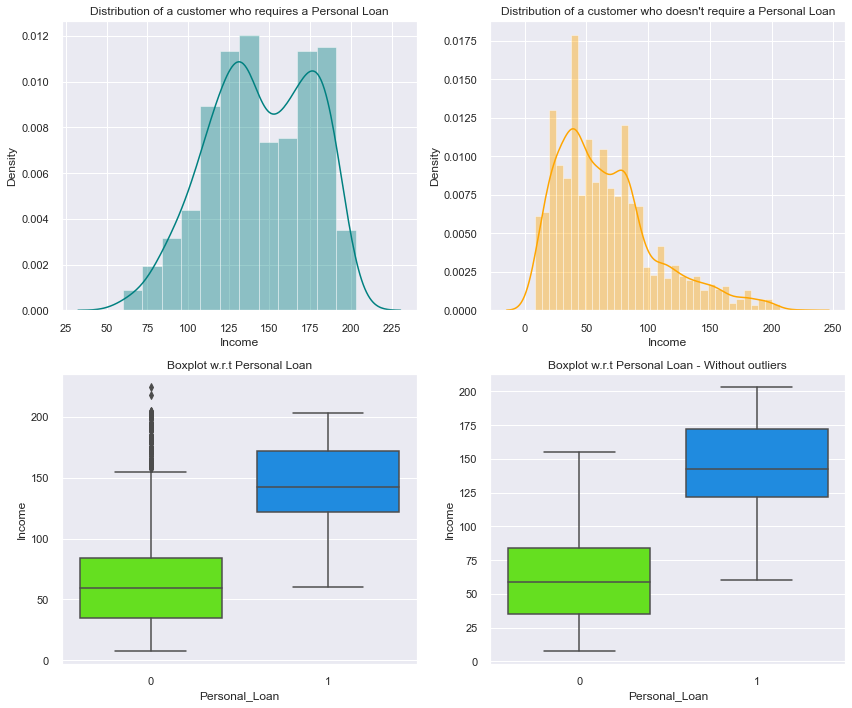

In [225]:
plot('Income')

### Personal_Loan vs CCAvg

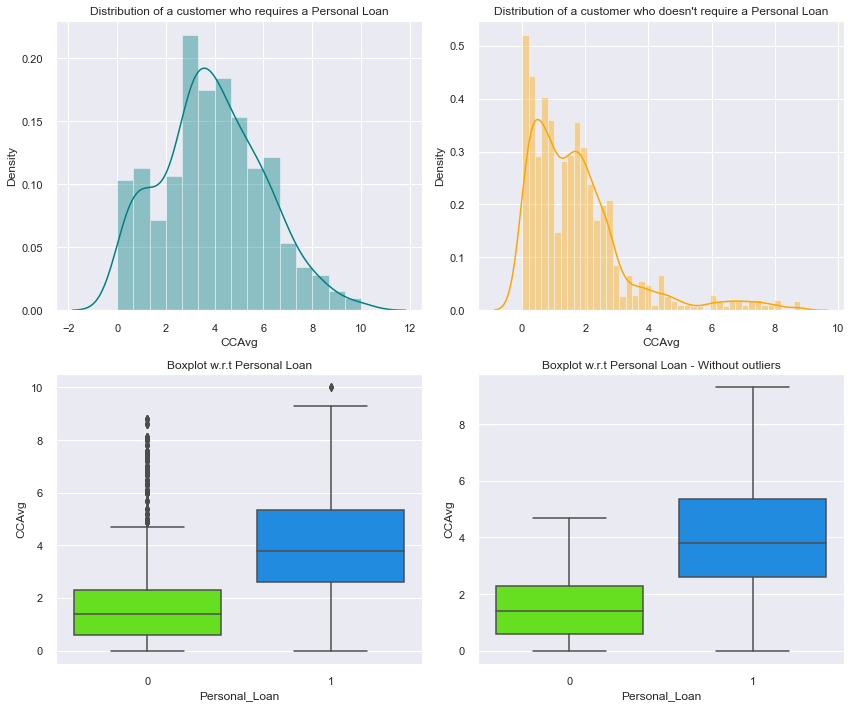

In [226]:
plot('CCAvg')

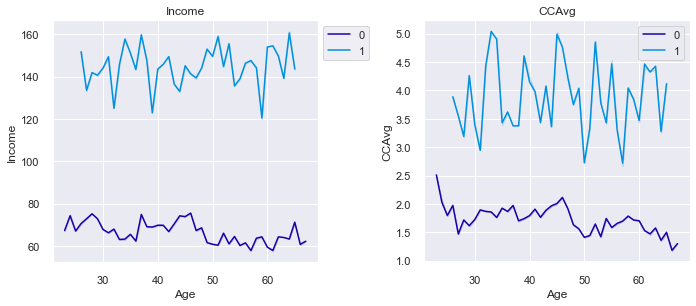

In [227]:
cols = data[['Income','CCAvg']].columns.tolist()
plt.figure(figsize=(15,12))
for i, variable in enumerate(cols):
                     plt.subplot(3,3,i+1)
                     sns.lineplot(data['Age'],data[variable],hue=data['Personal_Loan'],ci=0)
                     plt.tight_layout()
                     plt.title(variable)
                     plt.legend(bbox_to_anchor=(1, 1))
plt.show()

<ul>
    <li>Customers who require Personal Loans are  ones whose income fluctuates largely in relation to the increase in Age. I believe this exemplifies clearly how financial stability plays a big part in the possible need for a personal loan. Customers whose income fluctuates largely with age tend to have less income stability are more likely to choose a personal loan.</li>
</ul>

## Data Preparation

In [228]:
X = df.drop(['Personal_Loan'], axis=1)
Y = df[['Personal_Loan']] 

X = pd.get_dummies(X, columns=['Education'],drop_first=True)

#Splitting data in train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.30, random_state = 1)

In [229]:
##  Function to calculate different metric scores of the model - Accuracy, Recall and Precision
def get_metrics_score2(model,train,test,train_y,test_y,flag=True):
    '''
    model : classifier to predict values of X

    '''
    # defining an empty list to store train and test results
    
    score_list=[] 
    
    pred_train = model.predict(train)
    pred_test = model.predict(test)
    
    train_acc = accuracy_score(pred_train,train_y)
    test_acc = accuracy_score(pred_test,test_y)
    
    train_recall = recall_score(train_y,pred_train)
    test_recall = recall_score(test_y,pred_test)
    
    train_precision = precision_score(train_y,pred_train)
    test_precision = precision_score(test_y,pred_test)
    
    score_list.extend((train_acc,test_acc,train_recall,test_recall,train_precision,test_precision))
        
    # If the flag is set to True then only the following print statements will be dispayed. The default value is set to True.
    if flag == True: 
        print("Accuracy on training set : ",accuracy_score(pred_train,train_y))
        print("Accuracy on test set : ",accuracy_score(pred_test,test_y))
        print("Recall on training set : ",recall_score(train_y,pred_train))
        print("Recall on test set : ",recall_score(test_y,pred_test))
        print("Precision on training set : ",precision_score(train_y,pred_train))
        print("Precision on test set : ",precision_score(test_y,pred_test))
        print("ROC-AUC Score on training set:",metrics.roc_auc_score(train_y,pred_train))
        print("ROC-AUC Score on test set:",metrics.roc_auc_score(test_y,pred_test))
    
    return score_list # returning the list with train and test scores

In [230]:
##  Function to calculate different metric scores of the model - Accuracy, Recall and Precision
def get_metrics_score1(model,train,test,train_y,test_y,flag=True):
    '''
    model : classifier to predict values of X

    '''
    # defining an empty list to store train and test results
    
    score_list=[] 
    
    pred_train = model.predict(train)
    pred_test = model.predict(test)
    
    pred_train = np.round(pred_train)
    pred_test = np.round(pred_test)
    
    train_acc = accuracy_score(pred_train,train_y)
    test_acc = accuracy_score(pred_test,test_y)
    
    train_recall = recall_score(train_y,pred_train)
    test_recall = recall_score(test_y,pred_test)
    
    train_precision = precision_score(train_y,pred_train)
    test_precision = precision_score(test_y,pred_test)
    
    score_list.extend((train_acc,test_acc,train_recall,test_recall,train_precision,test_precision))
        
   # If the flag is set to True then only the following print statements will be dispayed. The default value is set to True.
    
    if flag == True: 
        print("Accuracy on training set : ",accuracy_score(pred_train,train_y))
        print("Accuracy on test set : ",accuracy_score(pred_test,test_y))
        print("Recall on training set : ",recall_score(train_y,pred_train))
        print("Recall on test set : ",recall_score(test_y,pred_test))
        print("Precision on training set : ",precision_score(train_y,pred_train))
        print("Precision on test set : ",precision_score(test_y,pred_test))
    return score_list # returning the list with train and test scores

In [231]:
## Defining a function for better visualization of confusion matrix
def make_confusion_matrix(y_actual,y_predict,labels=[1, 0]):
    '''
    y_predict: prediction of class
    y_actual : ground truth  
    '''
    cm=confusion_matrix( y_predict,y_actual, labels=[1, 0])
    data_cm = pd.DataFrame(cm, index = [i for i in ["1","0"]],
                  columns = [i for i in ['1','0']])
    group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}" for v1, v2 in
              zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    plt.figure(figsize = (7,5))
    sns.heatmap(data_cm, annot=labels,fmt='')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Linear Regression

In [232]:
# dataframe with numerical column only
num_feature_set = X.copy()
num_feature_set = add_constant(num_feature_set)
num_feature_set = num_feature_set.astype(float)

In [233]:
X_train, X_test, y_train, y_test = train_test_split(num_feature_set, Y, test_size=0.30, random_state = 1)

In [234]:
vif_series1 = pd.Series([variance_inflation_factor(num_feature_set.values,i) for i in range(num_feature_set.shape[1])],index=num_feature_set.columns, dtype = float)
print('Series before feature selection: \n\n{}\n'.format(vif_series1))

Series before feature selection: 

const                 29.329694
Age                    1.008620
Income                 1.864058
Family                 1.046639
CCAvg                  1.722991
Mortgage               1.050797
Securities_Account     1.133490
CD_Account             1.280904
CreditCard             1.104891
Education_2            1.269331
Education_3            1.247811
dtype: float64



In [235]:
logit = sm.Logit(y_train, X_train.astype(float))
lg = logit.fit()

print(lg.summary())

print('')
# Let's check model performances for this model
scores_LR = get_metrics_score1(lg,X_train,X_test,y_train,y_test,flag=True)

Optimization terminated successfully.
         Current function value: 0.115675
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:          Personal_Loan   No. Observations:                 3500
Model:                          Logit   Df Residuals:                     3489
Method:                           MLE   Df Model:                           10
Date:                Fri, 05 Nov 2021   Pseudo R-squ.:                  0.6304
Time:                        00:28:56   Log-Likelihood:                -404.86
converged:                       True   LL-Null:                       -1095.5
Covariance Type:            nonrobust   LLR p-value:                1.140e-290
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                -13.7417      0.809    -16.976      0.000     -15.328     -12.155
Age  

## Decision Trees

In [236]:
dTree = DecisionTreeClassifier(criterion = 'gini', random_state=1)
dTree.fit(X_train, y_train)

DecisionTreeClassifier(random_state=1)

In [237]:
dummy_data = pd.get_dummies(df, columns=['Family','Education','Securities_Account','CD_Account',
                                           'CreditCard'],drop_first=True)
dummy_data.head()

,Age,Income,CCAvg,Mortgage,Personal_Loan,Family_2,Family_3,Family_4,Education_2,Education_3,Securities_Account_True,CD_Account_True,CreditCard_True
0,25,49,1.6,0,False,0,0,1,0,0,1,0,0
1,45,34,1.5,0,False,0,1,0,0,0,1,0,0
2,39,11,1.0,0,False,0,0,0,0,0,0,0,0
3,35,100,2.7,0,False,0,0,0,1,0,0,0,0
4,35,45,1.0,0,False,0,0,1,1,0,0,0,1


In [238]:
column_names = list(dummy_data.columns)
column_names.remove('Personal_Loan')                     # Keep only names of features by removing the name of target variable
feature_names = column_names
print(feature_names)

['Age', 'Income', 'CCAvg', 'Mortgage', 'Family_2', 'Family_3', 'Family_4', 'Education_2', 'Education_3', 'Securities_Account_True', 'CD_Account_True', 'CreditCard_True']


In [239]:
X = dummy_data.drop('Personal_Loan',axis=1)                                                 # Features
y = dummy_data['Personal_Loan']                                             # Labels (Target Variable)
# converting target to integers - since some functions might not work with bool type

In [240]:
# Splitting data into training and test set:
X_train, X_test, y_train, y_test =train_test_split(X, y, test_size=0.3, random_state=1)
print(X_train.shape, X_test.shape)

(3500, 12) (1500, 12)


In [241]:
model = DecisionTreeClassifier(criterion='gini',class_weight={0:0.15,1:0.85},random_state=1)

In [242]:
model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight={0: 0.15, 1: 0.85}, random_state=1)

In [243]:
def make_confusion_matrix(model,y_actual,labels=[1, 0]):
    '''
    model : classifier to predict values of X
    y_actual : ground truth  
    
    '''
    y_predict = model.predict(X_test)
    cm=metrics.confusion_matrix( y_actual, y_predict, labels=[0, 1])
    df_cm = pd.DataFrame(cm, index = [i for i in ["Actual - No","Actual - Yes"]],
                  columns = [i for i in ['Predicted - No','Predicted - Yes']])
    group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}" for v1, v2 in
              zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    plt.figure(figsize = (10,7))
    sns.heatmap(df_cm, annot=labels,fmt='')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

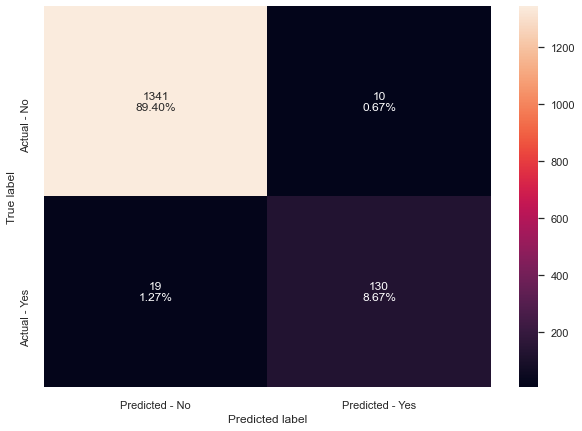

In [244]:
make_confusion_matrix(model,y_test)

In [245]:
y_train.value_counts(1)

False    0.905429
True     0.094571
Name: Personal_Loan, dtype: float64

### Observations:

<ul>
    <li>We only have 9% of positive classes, so if our model marks each sample as negative, then we'll also get 90.5% accuracy, hence accuracy is not a good metric to evaluate here.</li>
    <li>Our test data performs so poorly that it is clear that accuracy is not a good metric in this situation.</li>
</ul>

In [246]:
##  Function to calculate recall score
def get_recall_score(model):
    '''
    model : classifier to predict values of X

    '''
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    print("Recall on training set : ",metrics.recall_score(y_train,pred_train))
    print("Recall on test set : ",metrics.recall_score(y_test,pred_test))

In [247]:
get_recall_score(model)

Recall on training set :  1.0
Recall on test set :  0.87248322147651


### Observations:

<ul>
    <li>A full score of 1.0 on training data always reflects overfitting on the test data.</li>
</ul>

## Visualizing the Decision Tree

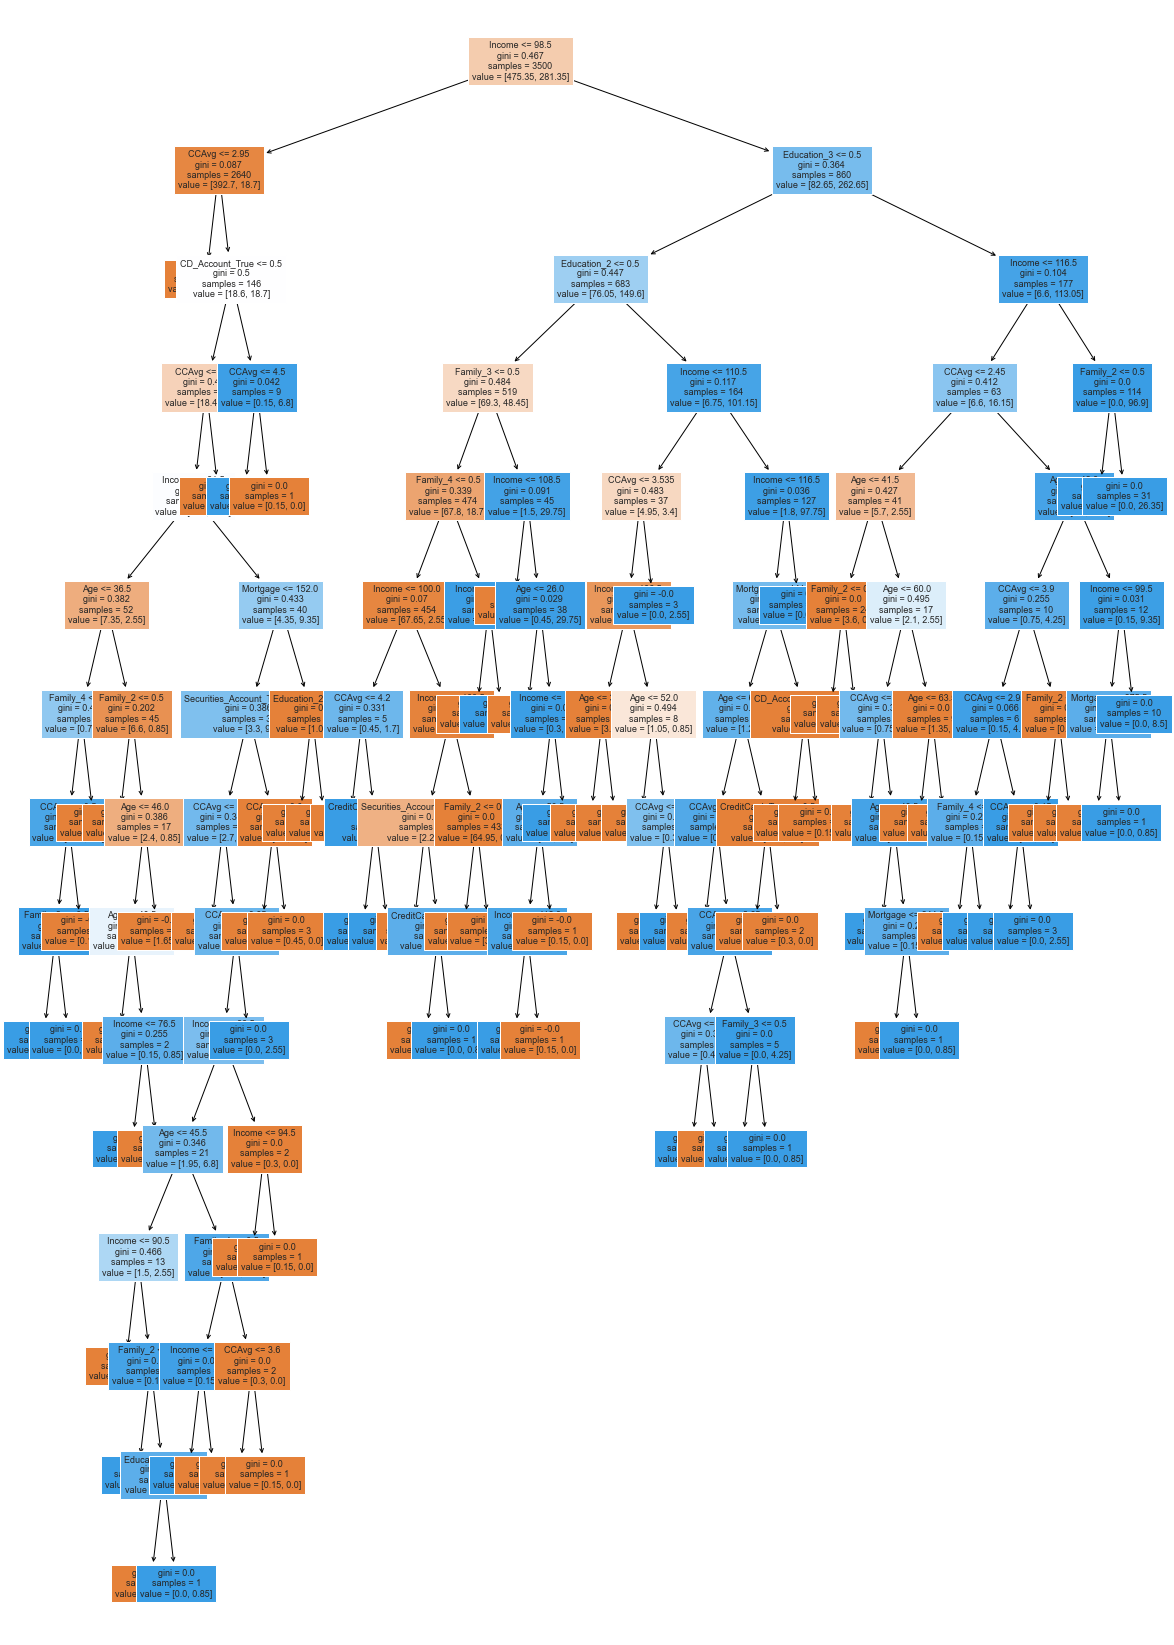

In [248]:
plt.figure(figsize=(20,30))
out = tree.plot_tree(model,feature_names=feature_names,filled=True,fontsize=9,node_ids=False,class_names=None,)
#below code will add arrows to the decision tree split if they are missing
for o in out:
     arrow = o.arrow_patch
     if arrow is not None:
        arrow.set_edgecolor('black')
        arrow.set_linewidth(1)
plt.show()

In [249]:
# Text report showing the rules of a decision tree -

print(tree.export_text(model,feature_names=feature_names,show_weights=True))

|--- Income <= 98.50
|   |--- CCAvg <= 2.95
|   |   |--- weights: [374.10, 0.00] class: False
|   |--- CCAvg >  2.95
|   |   |--- CD_Account_True <= 0.50
|   |   |   |--- CCAvg <= 3.95
|   |   |   |   |--- Income <= 81.50
|   |   |   |   |   |--- Age <= 36.50
|   |   |   |   |   |   |--- Family_4 <= 0.50
|   |   |   |   |   |   |   |--- CCAvg <= 3.50
|   |   |   |   |   |   |   |   |--- Family_2 <= 0.50
|   |   |   |   |   |   |   |   |   |--- weights: [0.00, 0.85] class: True
|   |   |   |   |   |   |   |   |--- Family_2 >  0.50
|   |   |   |   |   |   |   |   |   |--- weights: [0.00, 0.85] class: True
|   |   |   |   |   |   |   |--- CCAvg >  3.50
|   |   |   |   |   |   |   |   |--- weights: [0.15, 0.00] class: False
|   |   |   |   |   |   |--- Family_4 >  0.50
|   |   |   |   |   |   |   |--- weights: [0.60, 0.00] class: False
|   |   |   |   |   |--- Age >  36.50
|   |   |   |   |   |   |--- Family_2 <= 0.50
|   |   |   |   |   |   |   |--- weights: [4.20, 0.00] class: False
|   

In [250]:
# importance of features in the tree building ( The importance of a feature is computed as the 
#(normalized) total reduction of the criterion brought by that feature. It is also known as the Gini importance )

print (pd.DataFrame(model.feature_importances_, columns = ["Imp"], index = X_train.columns).sort_values(by = 'Imp', ascending = False))

                              Imp
Income                   0.598991
CCAvg                    0.091148
Education_2              0.088856
Family_4                 0.072555
Family_3                 0.070324
Education_3              0.035148
Age                      0.019144
CD_Account_True          0.011000
Mortgage                 0.006609
Securities_Account_True  0.004716
Family_2                 0.000789
CreditCard_True          0.000721


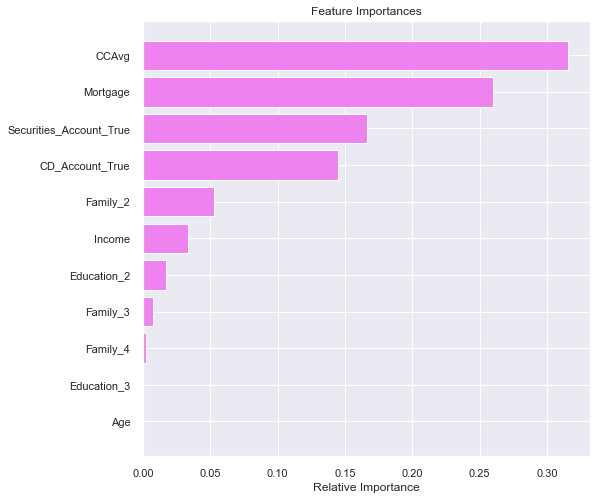

In [251]:
importances = dTree.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(8,8))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='violet', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

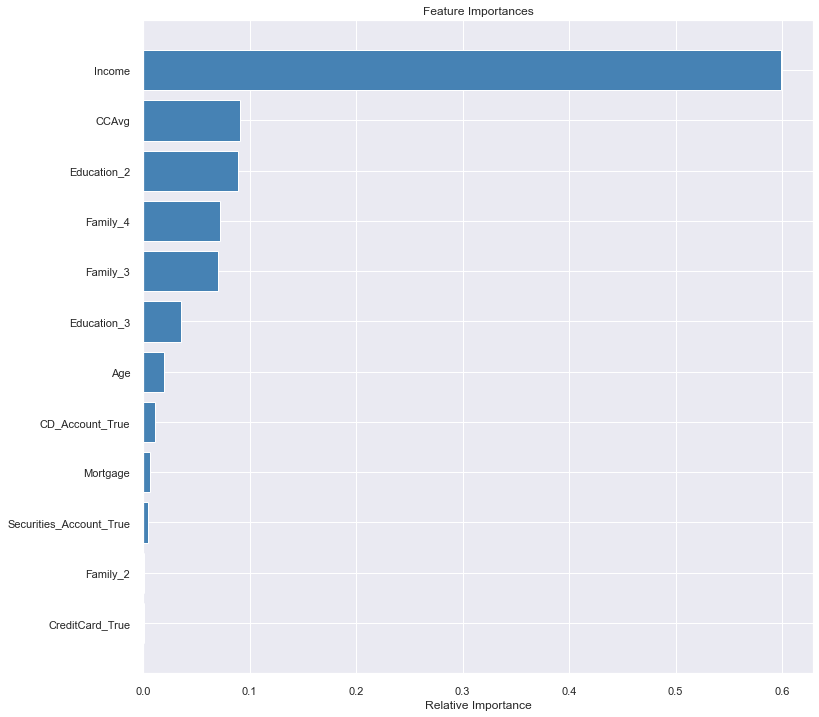

In [252]:
importances = model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='steelblue', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

### Observations:

<ul>
    <li>As noted by the decision tree above and from our earlier observations, Income is by far the most important factor in determining whether or not a customer has a personal loan.</li>
    <li>Income is by far the most important variable when determining whether or not an individual has a personal loan.</li>
    <li>Unfortunately, our earlier idea that credit cards could potentially be a gateway product for personal loans might have to be dismissed because it seems like whether or not a customer has a credit card holds little to no importance in this situation.</li>
</ul>

## Reducing over fitting


### Using GridSearch for Hyperparameter tuning of our tree model.

<ul>
    <li>Hyperparameter tuning is also tricky in the sense that there is no direct way to calculate how a change in the hyperparameter value will reduce the loss of your model, so we usually resort to experimentation. i.e we'll use Grid search</li>
    <li>Grid search is a tuning technique that attempts to compute the optimum values of hyperparameters.</li>
    <li>It is an exhaustive search that is performed on a the specific parameter values of a model.</li>
    <li>The parameters of the estimator/model used to apply these methods are optimized by cross-validated grid-search over a parameter grid.</li>
</ul>

In [253]:
from sklearn.model_selection import GridSearchCV

In [254]:
# Choose the type of classifier. 
estimator = DecisionTreeClassifier(random_state=1,class_weight = {0:.15,1:.85})

# Grid of parameters to choose from
parameters = {
            'max_depth': np.arange(1,10),
            'criterion': ['entropy','gini'],
            'splitter': ['best','random'],
            'min_impurity_decrease': [0.000001,0.00001,0.0001],
            'max_features': ['log2','sqrt']
             }

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

# Run the grid search
grid_obj = GridSearchCV(estimator, parameters, scoring=scorer,cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
estimator = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
estimator.fit(X_train, y_train)

DecisionTreeClassifier(class_weight={0: 0.15, 1: 0.85}, criterion='entropy',
                       max_depth=2, max_features='log2',
                       min_impurity_decrease=1e-06, random_state=1)

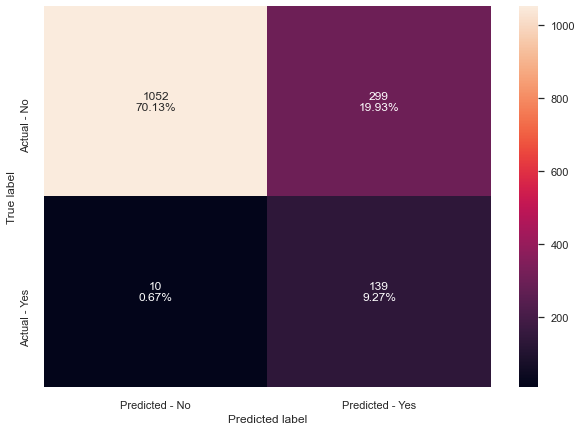

In [255]:
make_confusion_matrix(estimator,y_test)

In [256]:
get_recall_score(estimator)

Recall on training set :  0.9577039274924471
Recall on test set :  0.9328859060402684


### Observations:

<ul>
    <li>Recall has vastly improved both results for train and test set after hyperparameter tuning and we have a generalized model.</li>
</ul>

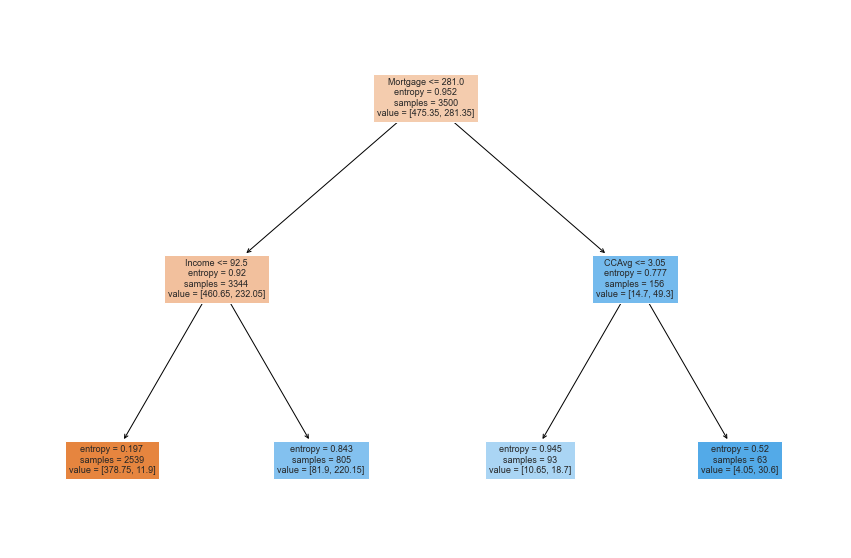

In [257]:
plt.figure(figsize=(15,10))
out = tree.plot_tree(estimator,feature_names=feature_names,filled=True,fontsize=9,node_ids=False,class_names=None)
for o in out:
    arrow = o.arrow_patch
    if arrow is not None:
        arrow.set_edgecolor('black')
        arrow.set_linewidth(1)
plt.show()

In [258]:
# Text report showing the rules of a decision tree -

print(tree.export_text(estimator,feature_names=feature_names,show_weights=True))

|--- Mortgage <= 281.00
|   |--- Income <= 92.50
|   |   |--- weights: [378.75, 11.90] class: False
|   |--- Income >  92.50
|   |   |--- weights: [81.90, 220.15] class: True
|--- Mortgage >  281.00
|   |--- CCAvg <= 3.05
|   |   |--- weights: [10.65, 18.70] class: True
|   |--- CCAvg >  3.05
|   |   |--- weights: [4.05, 30.60] class: True



In [259]:
# importance of features in the tree building ( The importance of a feature is computed as the 
#(normalized) total reduction of the 'criterion' brought by that feature. It is also known as the Gini importance )

print (pd.DataFrame(estimator.feature_importances_, columns = ["Imp"], index = X_train.columns).sort_values(by = 'Imp', ascending = False))

#Here we will see that importance of features has increased

                              Imp
Income                   0.890995
Mortgage                 0.097373
CCAvg                    0.011632
Age                      0.000000
Family_2                 0.000000
Family_3                 0.000000
Family_4                 0.000000
Education_2              0.000000
Education_3              0.000000
Securities_Account_True  0.000000
CD_Account_True          0.000000
CreditCard_True          0.000000


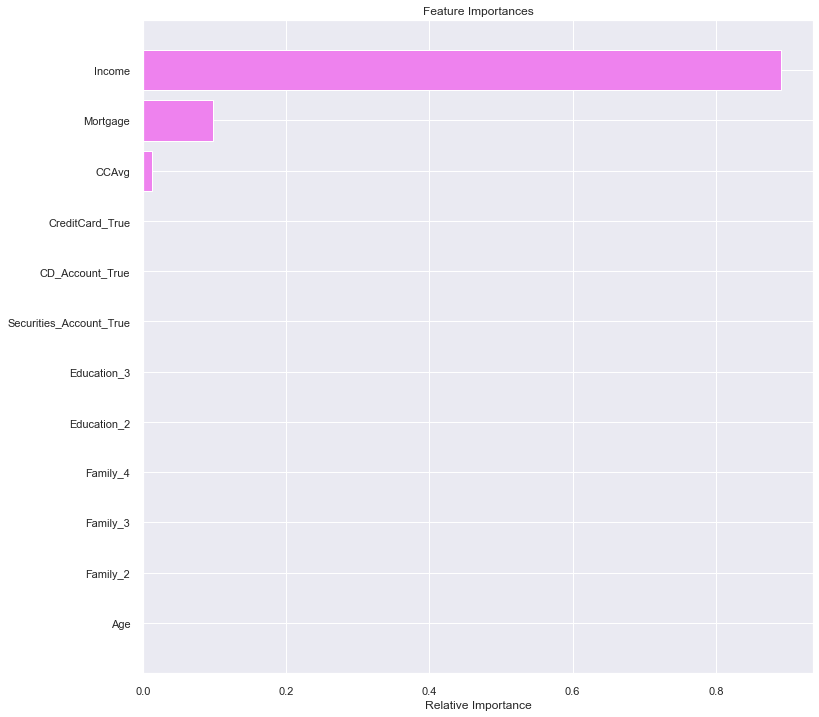

In [260]:
importances = estimator.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='violet', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

## Cost Complexity Pruning
The DecisionTreeClassifier provides parameters such as min_samples_leaf and max_depth to prevent a tree from overfiting. Cost complexity pruning provides another option to control the size of a tree. In DecisionTreeClassifier, this pruning technique is parameterized by the cost complexity parameter, ccp_alpha. Greater values of ccp_alpha increase the number of nodes pruned. Here we only show the effect of ccp_alpha on regularizing the trees and how to choose a ccp_alpha based on validation scores.

## Total impurity of leaves vs effective alphas of pruned tree
Minimal cost complexity pruning recursively finds the node with the "weakest link". The weakest link is characterized by an effective alpha, where the nodes with the smallest effective alpha are pruned first. To get an idea of what values of ccp_alpha could be appropriate, scikit-learn provides DecisionTreeClassifier.cost_complexity_pruning_path that returns the effective alphas and the corresponding total leaf impurities at each step of the pruning process. As alpha increases, more of the tree is pruned, which increases the total impurity of its leaves.

In [261]:
clf = DecisionTreeClassifier(random_state=1,class_weight = {0:0.15,1:0.85})
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [262]:
pd.DataFrame(path)

,ccp_alphas,impurities
0,0.000000e+00,-1.680102e-15
1,7.482671e-19,-1.679354e-15
2,7.482671e-19,-1.678605e-15
3,1.496534e-18,-1.677109e-15
4,1.760629e-18,-1.675348e-15
5,2.332833e-18,-1.673015e-15
6,2.494224e-18,-1.670521e-15
7,2.905037e-18,-1.667616e-15
8,3.521257e-18,-1.664095e-15
9,4.555626e-18,-1.659539e-15


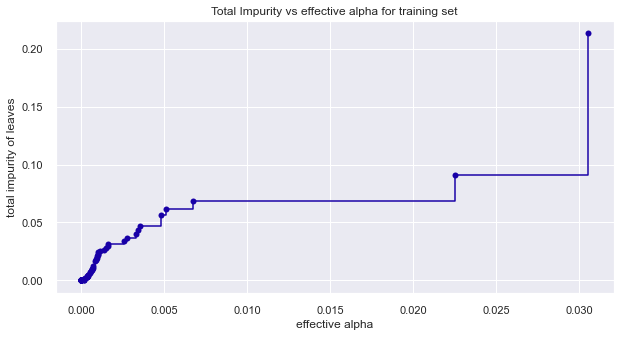

In [263]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")
plt.show()

In [264]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=1, ccp_alpha=ccp_alpha,class_weight = {0:0.15,1:0.85})
    clf.fit(X_train, y_train)
    clfs.append(clf)
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
      clfs[-1].tree_.node_count, ccp_alphas[-1]))

Number of nodes in the last tree is: 1 with ccp_alpha: 0.2537957148948097


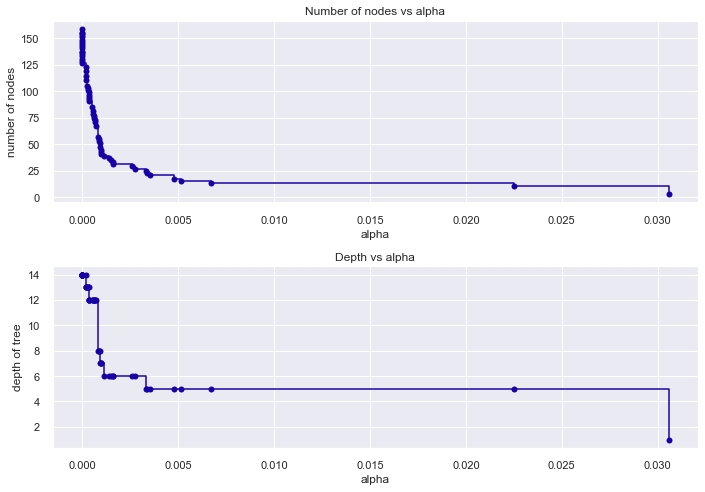

In [265]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1,figsize=(10,7))
ax[0].plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

In [266]:
recall_train=[]
for clf in clfs:
    pred_train3=clf.predict(X_train)
    values_train=metrics.recall_score(y_train,pred_train3)
    recall_train.append(values_train)

In [267]:
recall_test=[]
for clf in clfs:
    pred_test3=clf.predict(X_test)
    values_test=metrics.recall_score(y_test,pred_test3)
    recall_test.append(values_test)

In [268]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

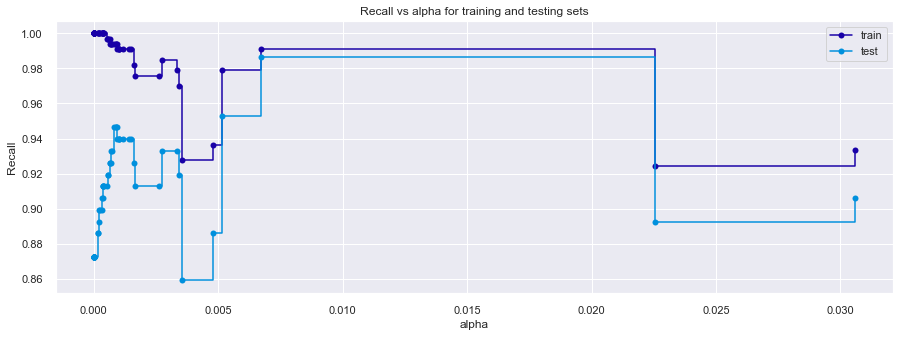

In [269]:
fig, ax = plt.subplots(figsize=(15,5))
ax.set_xlabel("alpha")
ax.set_ylabel("Recall")
ax.set_title("Recall vs alpha for training and testing sets")
ax.plot(ccp_alphas, recall_train, marker='o', label="train",
        drawstyle="steps-post",)
ax.plot(ccp_alphas, recall_test, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

### Observations:

<ul>
    <li>Interestingly, recall peaks when alpha is at a little over 0.005 and stays stagnant, however it will later drop.</li>
    <li>This indicates that this alpha will probably be most appropriate for our model.</li>
</ul>

In [270]:
# creating the model where we get highest train and test recall
index_best_model = np.argmax(recall_test)
best_model = clfs[index_best_model]
print(best_model)

DecisionTreeClassifier(ccp_alpha=0.006725813690406734,
                       class_weight={0: 0.15, 1: 0.85}, random_state=1)


In [271]:
best_model.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.006725813690406734,
                       class_weight={0: 0.15, 1: 0.85}, random_state=1)

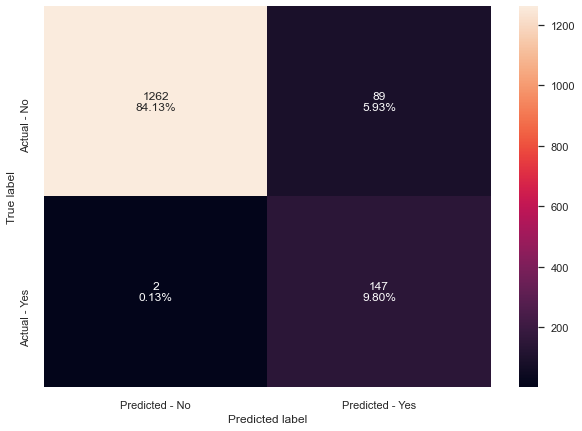

In [272]:
make_confusion_matrix(best_model,y_test)

In [273]:
get_recall_score(best_model)

Recall on training set :  0.9909365558912386
Recall on test set :  0.9865771812080537


## Visualizing the Decision Tree

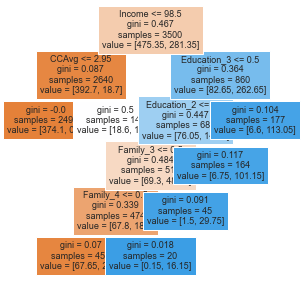

In [274]:
plt.figure(figsize=(5,5))

out = tree.plot_tree(best_model,feature_names=feature_names,filled=True,fontsize=9,node_ids=False,class_names=None)
for o in out:
    arrow = o.arrow_patch
    if arrow is not None:
        arrow.set_edgecolor('black')
        arrow.set_linewidth(1)
plt.show()

In [275]:
best_model2 = DecisionTreeClassifier(ccp_alpha=0.002,
                       class_weight={0: 0.15, 1: 0.85}, random_state=1)
best_model2.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.002, class_weight={0: 0.15, 1: 0.85},
                       random_state=1)

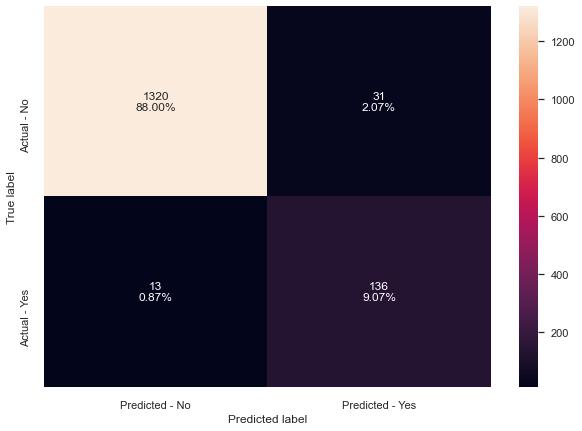

In [276]:
make_confusion_matrix(best_model2,y_test)

In [277]:
get_recall_score(best_model2)

Recall on training set :  0.9758308157099698
Recall on test set :  0.912751677852349


### Observations:

<ul>
    <li>The results have improved from the initial model and we have got higher recall than the hyperparameter tuned model and generalized decision tree - having comparable performance on training and test set.</li>
</ul>

## Visualizing the Decision Tree

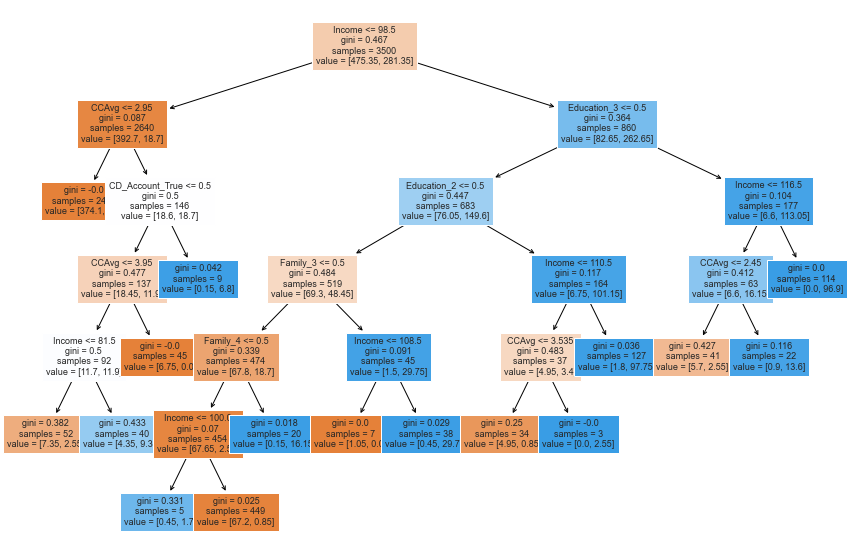

In [278]:
plt.figure(figsize=(15,10))

out = tree.plot_tree(best_model2,feature_names=feature_names,filled=True,fontsize=9,node_ids=False,class_names=None)
for o in out:
    arrow = o.arrow_patch
    if arrow is not None:
        arrow.set_edgecolor('black')
        arrow.set_linewidth(1)
plt.show()

In [279]:
# Text report showing the rules of a decision tree -

print(tree.export_text(best_model2,feature_names=feature_names,show_weights=True))

|--- Income <= 98.50
|   |--- CCAvg <= 2.95
|   |   |--- weights: [374.10, 0.00] class: False
|   |--- CCAvg >  2.95
|   |   |--- CD_Account_True <= 0.50
|   |   |   |--- CCAvg <= 3.95
|   |   |   |   |--- Income <= 81.50
|   |   |   |   |   |--- weights: [7.35, 2.55] class: False
|   |   |   |   |--- Income >  81.50
|   |   |   |   |   |--- weights: [4.35, 9.35] class: True
|   |   |   |--- CCAvg >  3.95
|   |   |   |   |--- weights: [6.75, 0.00] class: False
|   |   |--- CD_Account_True >  0.50
|   |   |   |--- weights: [0.15, 6.80] class: True
|--- Income >  98.50
|   |--- Education_3 <= 0.50
|   |   |--- Education_2 <= 0.50
|   |   |   |--- Family_3 <= 0.50
|   |   |   |   |--- Family_4 <= 0.50
|   |   |   |   |   |--- Income <= 100.00
|   |   |   |   |   |   |--- weights: [0.45, 1.70] class: True
|   |   |   |   |   |--- Income >  100.00
|   |   |   |   |   |   |--- weights: [67.20, 0.85] class: False
|   |   |   |   |--- Family_4 >  0.50
|   |   |   |   |   |--- weights: [0.15, 1

In [280]:
# importance of features in the tree building ( The importance of a feature is computed as the 
#(normalized) total reduction of the 'criterion' brought by that feature. It is also known as the Gini importance )

print (pd.DataFrame(best_model2.feature_importances_, columns = ["Imp"], index = X_train.columns).sort_values(by = 'Imp', ascending = False))

                              Imp
Income                   0.627273
Education_2              0.094494
CCAvg                    0.080251
Family_3                 0.075399
Family_4                 0.073107
Education_3              0.037684
CD_Account_True          0.011793
Age                      0.000000
Mortgage                 0.000000
Family_2                 0.000000
Securities_Account_True  0.000000
CreditCard_True          0.000000


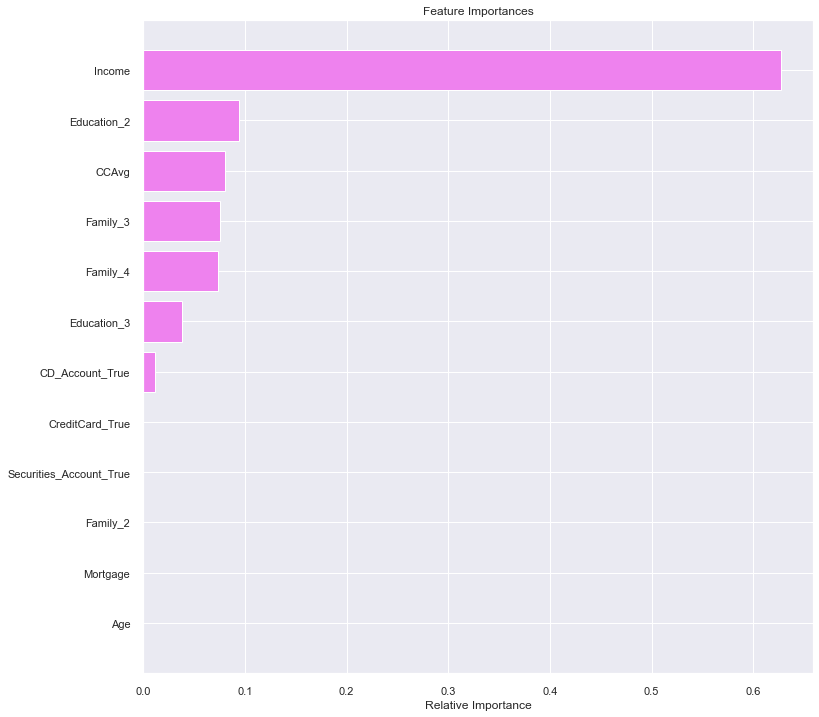

In [281]:
importances = best_model2.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='violet', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

## Comparing all the Decision Tree models

In [282]:
comparison_frame = pd.DataFrame({'Model':['Initial decision tree model','Decision tree with hyperparameter tuning',
                                          'Decision tree with post-pruning'], 'Train_Recall':[1,0.95,0.97], 'Test_Recall':[0.87,0.93,0.91]}) 
comparison_frame

,Model,Train_Recall,Test_Recall
0,Initial decision tree model,1.00,0.87
1,Decision tree with hyperparameter tuning,0.95,0.93
2,Decision tree with post-pruning,0.97,0.91


### Observations:

<ul>
    <li>Decision tree with hyperparameter tuning has given the best recall score on the data.</li>
</ul>

## Conclusions:

<ul>
    <li>We analyzed the "AllLife Bank" .csv file using different techniques and used Linear Regressiona and Decision Tree Classifier to build a predictive model for the next marketing campaign.</li>
    <li>The model built can be used to predict the most important factors that come into play when determining whether a customer will choose to open a personal loan or not.</li>
    <li>We visualized different trees and their confusion matrix to get a better understanding of the model. Easy interpretation is one of the key benefits of Decision Trees.</li>
    <li>We verified the fact that how much less data preparation is needed for Decision Trees and such a simple model gave good results even with outliers and imbalanced classes which shows the robustness of Decision Trees.</li>
    <li>Whether a customer has previous experience in dealing with a large borrowed asset (in this case, a mortgage), their income, and their monthly credit card spending are the most important variables in predicting the likelihood a customer will open a personal loan with AllLife Bank.</li>
    <li>We established the importance of hyper-parameters/ pruning to reduce overfitting.</li>
</ul>

## Recommendations:


According to the decision tree model -

<ul>
    <li>Previous experience with large borrowed assets play a large factor in determining whether a customer will open a personal loan.</li>
    <li>More than this though, it seems that by an overwhelming majority, higher income customers from higher education brackets are the most likely to open a personal loan.</li>
    <li>Though we found that having small borrowed assets such as credit cards do not play a large role in helping customers convert to asset customers with a personal loan, I believe this cannot go unnoticed. If the desire is to increase and maximize profits through interest garnered on borrowed products, I believe that employing a credit card campaign in addition to the  original personal loan campaign is likely to expand the customer base in terms of variability.</li>
    <li>In addition, because the customer base for loans seems to for those of higher income, another recommendation is perhaps offering smaller-sized personal loans with lowered interest rates in order to make these products available to all customers regardless of income. Though the profits garnered from these smaller loans will not be as great, on a wider-scale, the company will still increase profits and there is potential that the customers will open a larger loan in the future.</li>
    <li>Overall, I believe 2-3 additional campaigns should be launched: the original personal loan campaign aimed towards customers of higher income, a credit card campaign that will introduce borrowed products to individuals who might not have previous experience with asset products, and a smaller personal loan campaign aimed towards individuals who might have previous experience with borrowed products but that is affordable enough for customers regardless of annual income. This way, the potential for profits to increase through garnered interest will be higher due to the larger demographic becoming asset customers.</li>
</ul>